## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawcomp' #dataset-compression
TRANSFORM = 'cwt-strong_intensity' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
strong_intensity_cwt_1e5rawcomp_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os
import numpy as np

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawcomp\\cwt\\strong_intensity'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


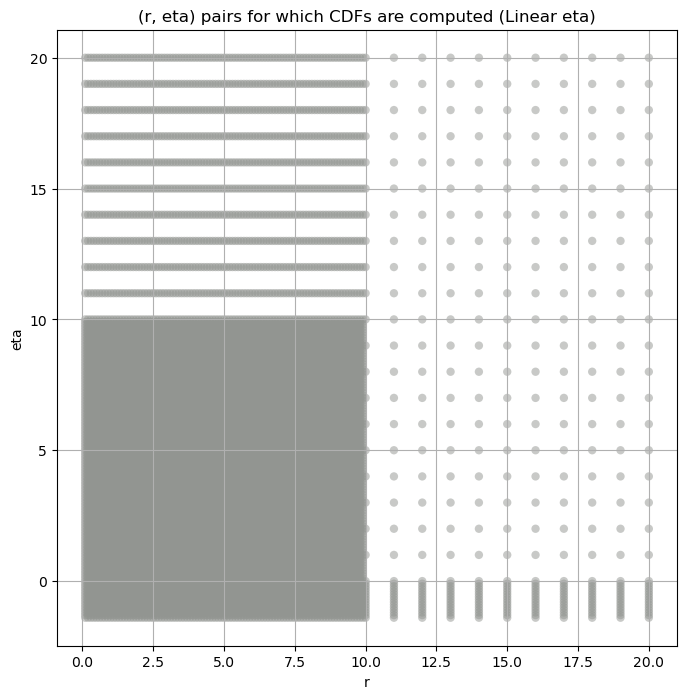

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 18


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 21


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 24


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 27


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 31


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     6.853427e+08  6.000865e+08  7.770383e+08  22.935051   19.237541   
5     1.721802e+09  1.590356e+09  1.858356e+09   7.159598    6.277525   
8     1.588727e+09  1.482723e+09  1.697909e+09   4.966211    4.375383   
11    1.416653e+09  1.330225e+09  1.504607e+09   3.758611    3.396935   
14    4.129085e+08  3.789787e+08  4.479632e+08   8.569131    7.614952   
18    8.665144e+07  7.953336e+07  9.428525e+07   8.930678    7.110191   
21    3.355825e+07  3.043884e+07  3.696326e+07  12.006084    8.988194   
24    1.647439e+07  1.424752e+07  1.894558e+07  28.794476   22.496632   
27    7.202204e+06  6.039485e+06  8.489410e+06  41.684950   32.753284   
31    2.123527e+05  1.700635e+05  2.704926e+05  79.023926   42.148514   

      kurt_upper  total_samples  
band                             
2      27.800936     57630782.0  
5       8.111173     57630782.0  
8       5.579913     57630782.0  
11      4.138503     57630782.0  
14      9.577575     57630782.0  
18     11.247792     57630782.0  
21     16.476372     57630782.0  
24     36.237900     57630782.0  
27     52.515106     57630782.0  
31    215.783400     57630782.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                                
2     6.853427e+08   6.853427e+08    6.531465e+08    6.295416e+08   
5     1.721802e+09   1.721802e+09    1.686650e+09    1.657802e+09   
8     1.588727e+09   1.588727e+09    1.563826e+09    1.542135e+09   
11    1.416653e+09   1.416653e+09    1.401338e+09    1.387424e+09   
14    4.129085e+08   4.129085e+08    4.042176e+08    3.967696e+08   
18    8.665144e+07   8.665144e+07    8.396429e+07    8.204191e+07   
21    3.355825e+07   3.355825e+07    3.221028e+07    3.130845e+07   
24    1.647439e+07   1.647439e+07    1.543630e+07    1.469753e+07   
27    7.202204e+06   7.202204e+06    6.643768e+06    6.249490e+06   
31    2.123527e+05   2.123527e+05    1.862964e+05    1.721235e+05   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2       6.090072e+08     5.905061e+08     5.577641e+08     5.290982e+08   
5       1.631772e+09     1.607767e+09     1.564143e+09     1.524643e+09   
8       1.522263e+09     1.503787e+09     1.470008e+09     1.439388e+09   
11      1.374269e+09     1.361682e+09     1.337879e+09     1.315576e+09   
14      3.899800e+08     3.836677e+08     3.721286e+08     3.616909e+08   
18      8.040676e+07     7.895410e+07     7.642112e+07     7.423316e+07   
21      3.056278e+07     2.991391e+07     2.880720e+07     2.787381e+07   
24      1.408406e+07     1.355240e+07     1.265602e+07     1.191351e+07   
27      5.923882e+06     5.642984e+06     5.172590e+06     4.785922e+06   
31      1.610068e+05     1.517847e+05     1.369400e+05     1.252365e+05   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2        5.033917e+08     4.800542e+08     4.587546e+08     4.044793e+08  
5        1.488280e+09     1.454460e+09     1.422803e+09     1.338065e+09  
8        1.411182e+09     1.384940e+09     1.360330e+09     1.293888e+09  
11       1.294483e+09     1.274410e+09     1.255218e+09     1.201983e+09  
14       3.521083e+08     3.432095e+08     3.348843e+08     3.126061e+08  
18       7.228890e+07     7.052989e+07     6.891840e+07     6.474144e+07  
21       2.706043e+07     2.633631e+07     2.568168e+07     2.401396e+07  
24       1.127972e+07     1.072743e+07     1.023906e+07     9.050581e+06  
27       4.457948e+06     4.173921e+06     3.924144e+06     3.322468e+06  
31       1.156297e+05     1.075258e+05     1.005555e+05     8.429229e+04

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.012973672592467955 685342700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.011951002232952233 653146500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.012697815535409794 629541600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.013382952358128863 609007200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.014024095803661776 590506100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.013553157422706508 557764100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.01464109468472256 529098180.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.015676371749834873 503391680.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.015269644876960215 480054200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.016210584780486616 458754600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.017646675864594157 404479260.0
Number of samples: 100000, Without approximation : 57630782.0


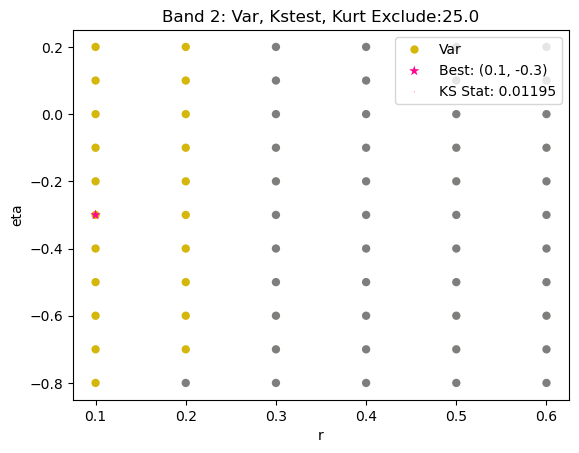

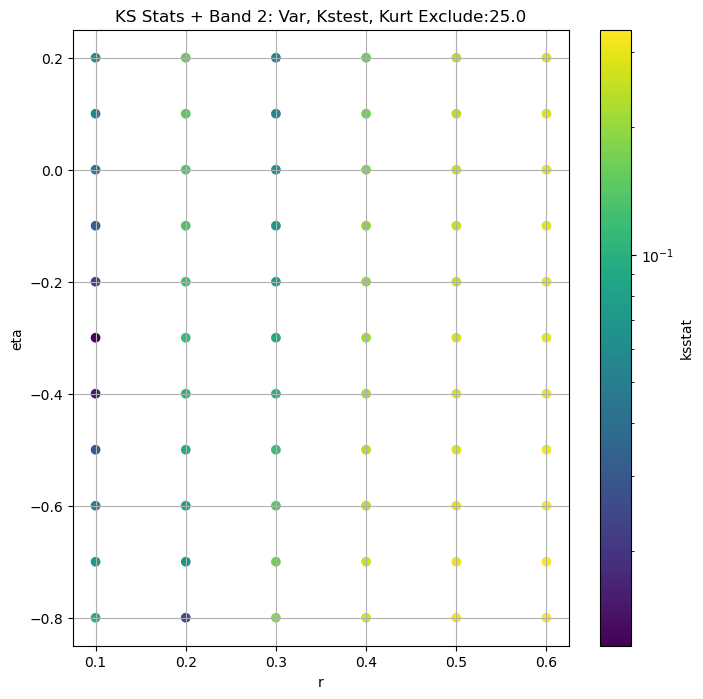

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.035562050910148454 1721802200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.03656339820192836 1686649700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.036976718682082355 1657801600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.036976718682082355 1631772400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.03690451591815397 1607767300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.036976718682082355 1564142700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.036976718682082355 1524643500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.036378475751150274 1488280300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.03551509483006682 1454460300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.03469819287021908 1422802700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.036030361817098996 1338065300.0
Number of samples: 100000, Without approximation : 57630782.0


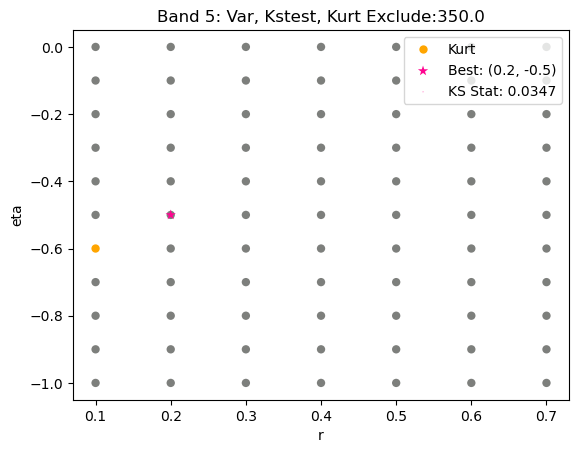

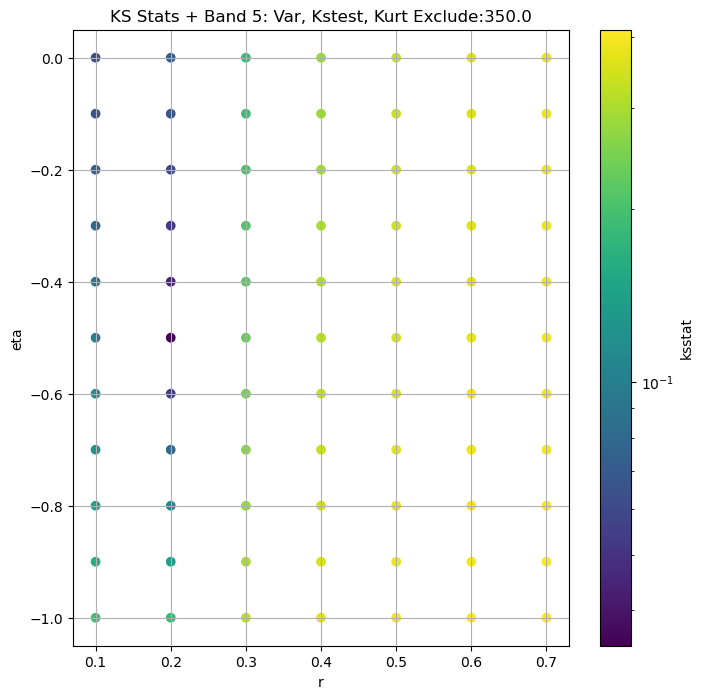

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.025160887700466275 1588726900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.02618211213019979 1563826000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.02708449752662584 1542134800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.027626750381270937 1522263300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.027297537201587563 1503787300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.026687961535790894 1470007700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.027942627680779014 1439387800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.029213588664534287 1411181800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.028749196442911462 1384940400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.02851254521267345 1360329900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.030212898399659405 1293887700.0
Number of samples: 100000, Without approximation : 57630782.0


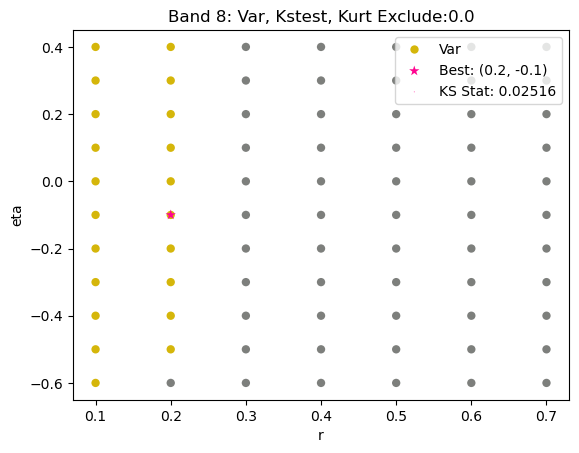

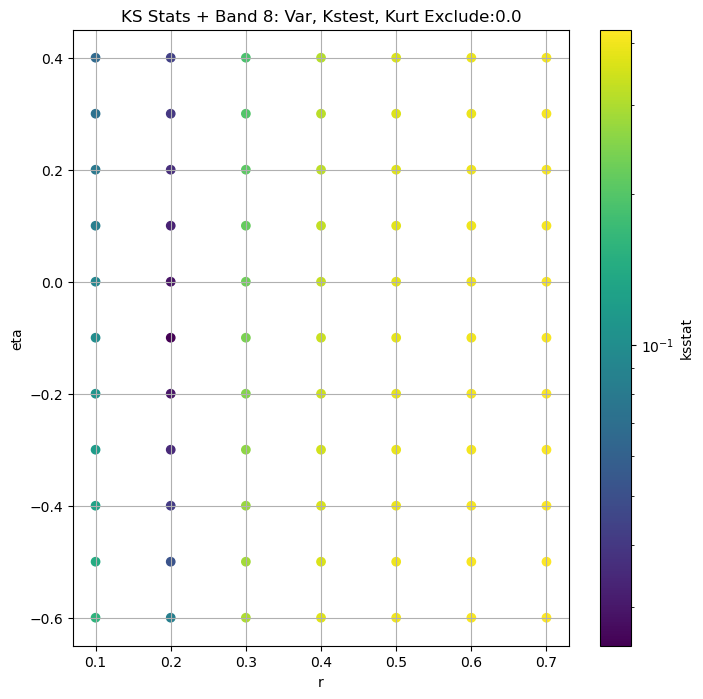

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.02930772574838343 1416652800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.029927529099806532 1401338500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.030498258015301094 1387424400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.030502724072373255 1374269200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.030188682783018728 1361681900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.029591234991608484 1337878500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.030437235610086738 1315575700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.03135729661785899 1294482600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.032249097863797094 1274409900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.032398936240031484 1255217500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.032960079007109275 1201982600.0
Number of samples: 100000, Without approximation : 57630782.0


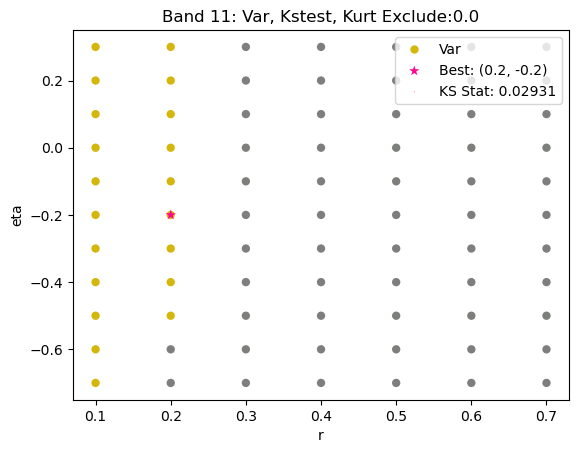

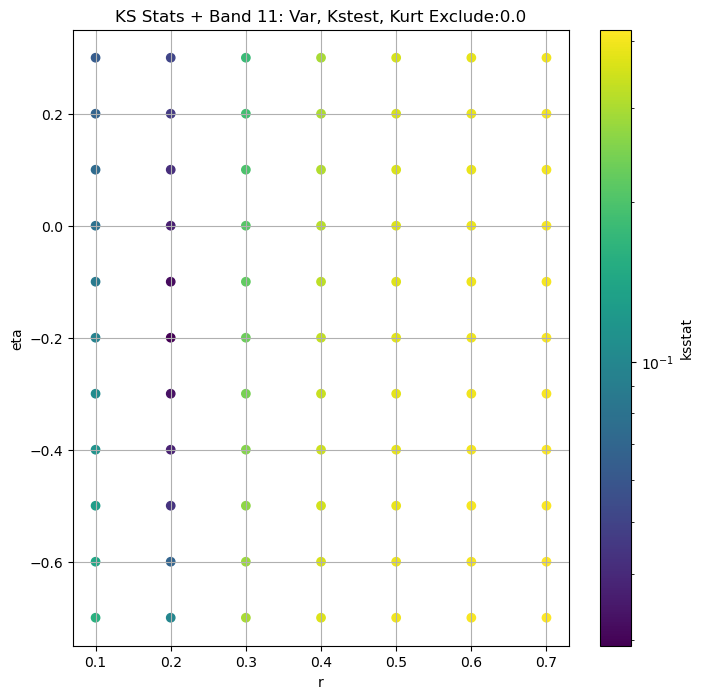

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.01989832333908892 412908540.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.019513729134200464 404217630.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.02043101513377288 396769570.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.02128523155067008 389979970.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.02209461323863604 383667700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.023620689738005796 372128600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.025048222256353836 361690900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.02470123649985595 352108260.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.02381704793346351 343209470.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.024021358978042806 334884260.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.027411051375364037 312606140.0
Number of samples: 100000, Without approximation : 57630782.0


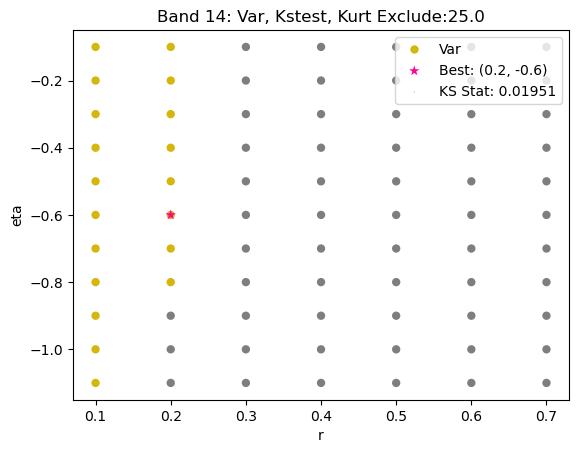

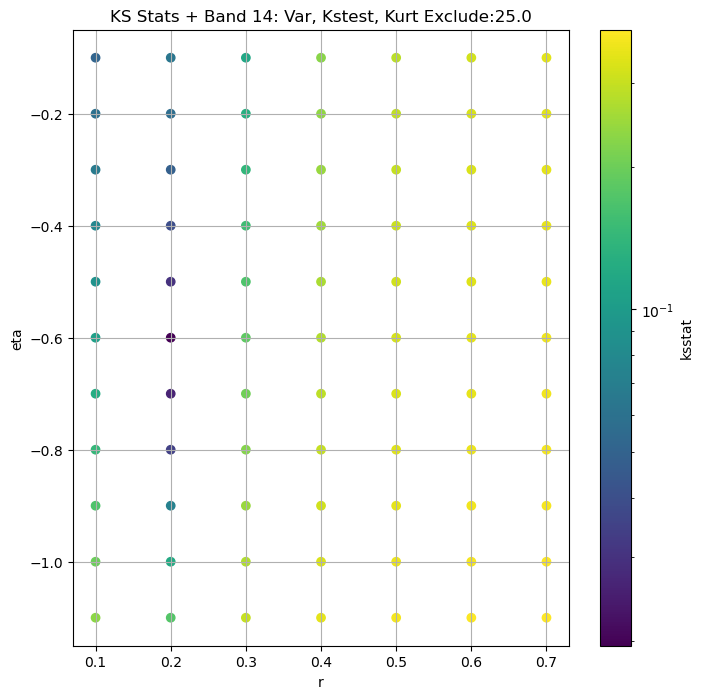

####
Band  18


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 0 0.01988031526133227 86651440.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 25 0.021447778454894983 83964290.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 50 0.02081652539210943 82041910.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 75 0.020548160495907686 80406760.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 100 0.021561214608289192 78954104.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 150 0.023389292612670087 76421120.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 200 0.022851587709743715 74233160.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 250 0.02355699931289923 72288900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 300 0.024928985522996272 70529890.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 350 0.025115474088973078 68918400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 500 0.027215688794211434 64741444.0
Number of samples: 100000, Without approximation : 57630782.0


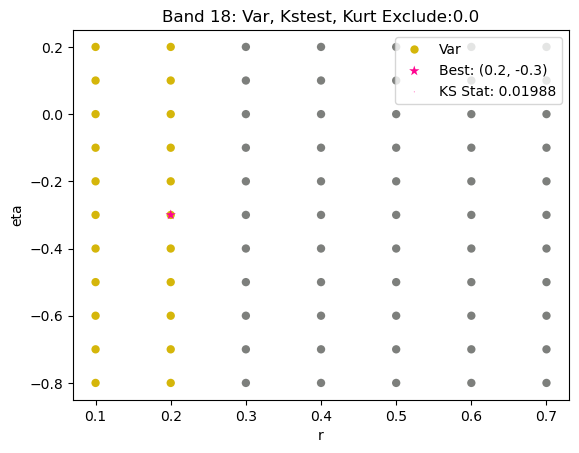

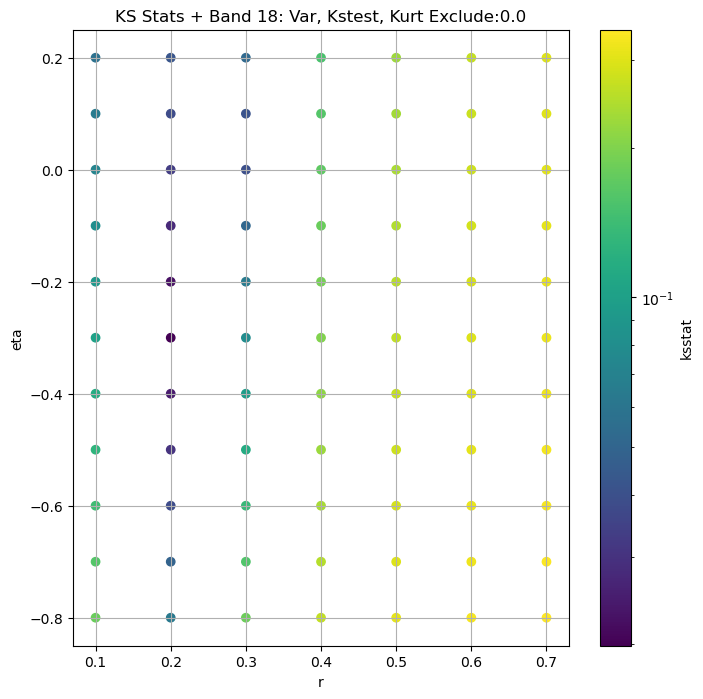

####
Band  21


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 0 0.018565648451581096 33558250.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 25 0.02083280397382939 32210282.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 50 0.021473561651081496 31308454.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 75 0.02081713699503107 30562776.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 100 0.020247022071146148 29913908.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 150 0.02204784321993712 28807196.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 200 0.02382543071334524 27873806.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 250 0.023840304863548933 27060432.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 300 0.023101249156986636 26336310.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 350 0.024405160582058327 25681682.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 500 0.02610408086278082 24013956.0
Number of samples: 100000, Without approximation : 57630782.0


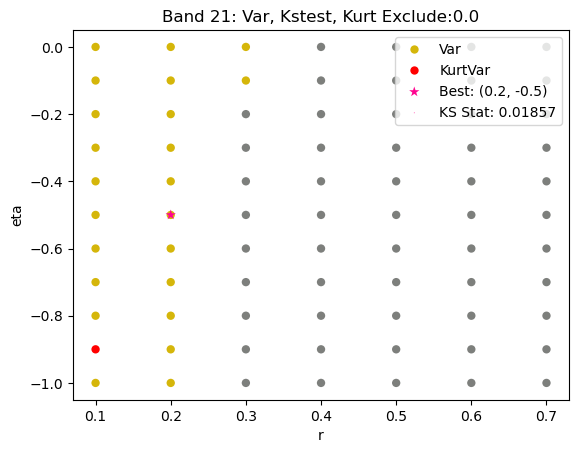

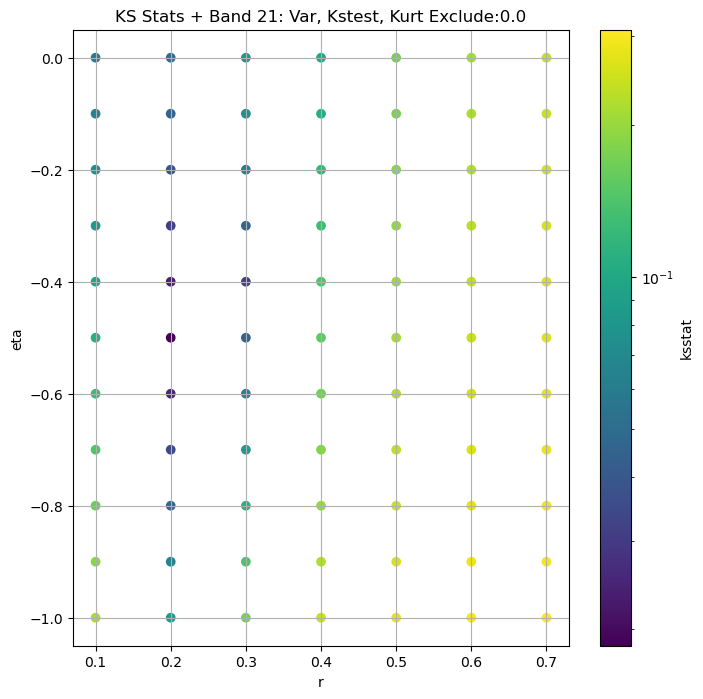

####
Band  24


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 0 0.0071053066378250485 16474387.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 25 0.009429528021950156 15436296.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 50 0.01177902912185333 14697531.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 75 0.013853261825407165 14084056.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 100 0.0157465585503955 13552396.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 150 0.016822924473121392 12656024.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 200 0.014795527748194037 11913508.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 250 0.014865044249100137 11279723.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 300 0.01702677185832943 10727427.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 350 0.019104461309691095 10239060.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 500 0.020420830002421786 9050581.0
Number of samples: 100000, Without approximation : 57630782.0


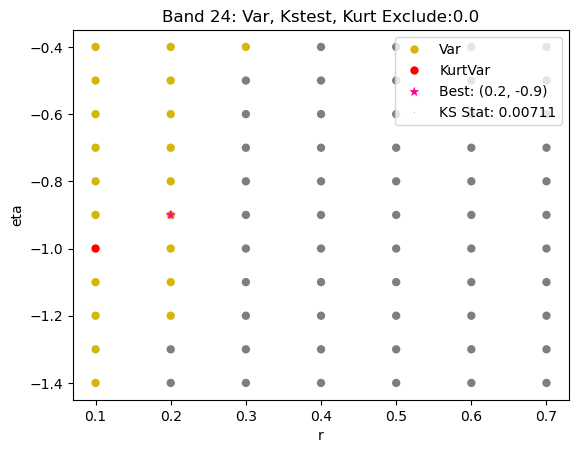

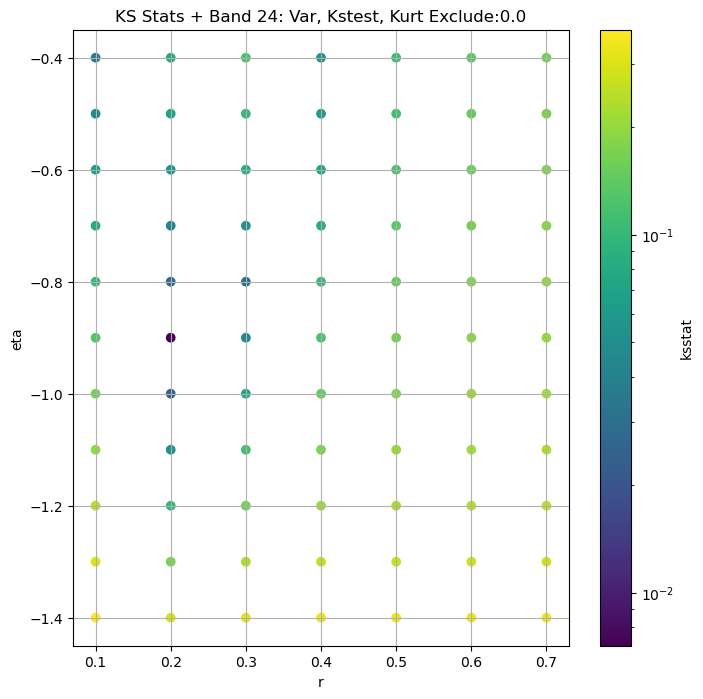

####
Band  27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 0 0.013225874101657209 7202204.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 25 0.012690468495754281 6643767.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 50 0.010511790353985417 6249489.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 75 0.010393020471409997 5923882.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 100 0.01029410199820413 5642984.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 150 0.01012775044887615 5172590.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 200 0.009987818003923787 4785922.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 250 0.009866365312565462 4457948.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 300 0.0114690534192885 4173921.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 350 0.014622202753414082 3924144.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 500 0.01405706071963575 3322468.0
Number of samples: 100000, Without approximation : 57630782.0


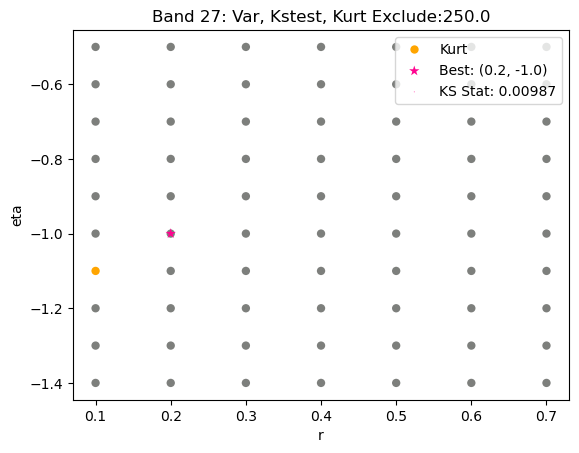

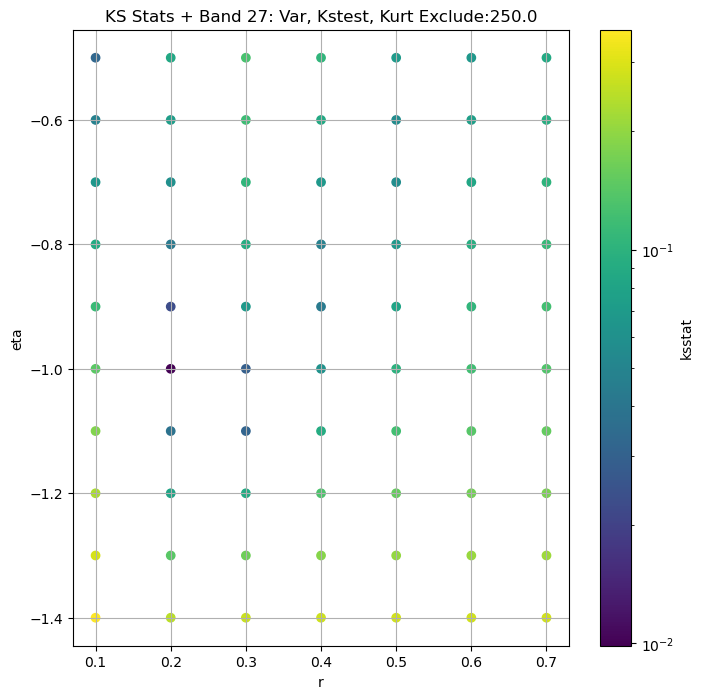

####
Band  31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 0 0.02938757200234815 212352.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 25 0.02910672173642187 186296.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 50 0.02893367611093761 172123.53


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 75 0.02878606927375521 161006.83


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 100 0.028654527123851525 151784.72


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 150 0.02894305104094419 136940.05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 200 0.02870028952936099 125236.49


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 250 0.02847478548456911 115629.66


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 300 0.028262185329165412 107525.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 350 0.02805975478117201 100555.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 500 0.030502116972766335 84292.29
Number of samples: 100000, Without approximation : 57630782.0


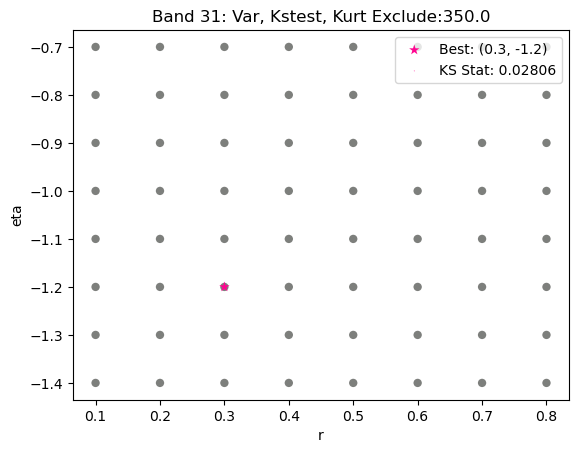

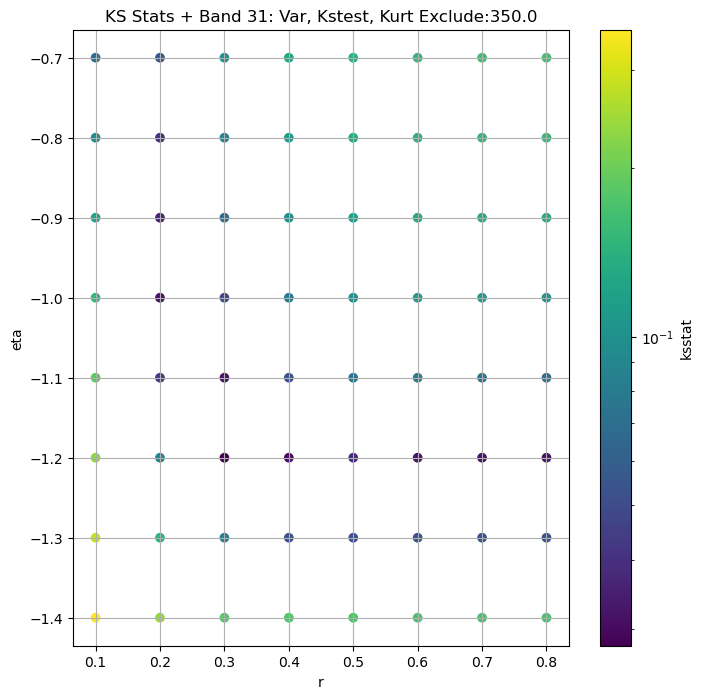

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     6.853427e+08  6.000865e+08  7.770383e+08  22.935051   19.237541   
5     1.721802e+09  1.590356e+09  1.858356e+09   7.159598    6.277525   
8     1.588727e+09  1.482723e+09  1.697909e+09   4.966211    4.375383   
11    1.416653e+09  1.330225e+09  1.504607e+09   3.758611    3.396935   
14    4.129085e+08  3.789787e+08  4.479632e+08   8.569131    7.614952   
18    8.665144e+07  7.953336e+07  9.428525e+07   8.930678    7.110191   
21    3.355825e+07  3.043884e+07  3.696326e+07  12.006084    8.988194   
24    1.647439e+07  1.424752e+07  1.894558e+07  28.794476   22.496632   
27    7.202204e+06  6.039485e+06  8.489410e+06  41.684950   32.753284   
31    2.123527e+05  1.700635e+05  2.704926e+05  79.023926   42.148514   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      27.800936     57630782.0             0.011951        0.1         -0.3   
5       8.111173     57630782.0             0.034698        0.2         -0.5   
8       5.579913     57630782.0             0.025161        0.2         -0.1   
11      4.138503     57630782.0             0.029308        0.2         -0.2   
14      9.577575     57630782.0             0.019514        0.2         -0.6   
18     11.247792     57630782.0             0.019880        0.2         -0.3   
21     16.476372     57630782.0             0.018566        0.2         -0.5   
24     36.237900     57630782.0             0.007105        0.2         -0.9   
27     52.515106     57630782.0             0.009866        0.2         -1.0   
31    215.783400     57630782.0             0.028060        0.3         -1.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2          0.000510                    25.0        6.531465e+08   
5      94100.706878                   350.0        1.422803e+09   
8      28656.690332                     0.0        1.588727e+09   
11     34273.383005                     0.0        1.416653e+09   
14     39413.636284                    25.0        4.042176e+08   
18      2865.457672                     0.0        8.665144e+07   
21      2219.460847                     0.0        3.355825e+07   
24      6537.455159                     0.0        1.647439e+07   
27      3166.929781                   250.0        4.457948e+06   
31     10858.502435                   350.0        1.005555e+05   

      kstest_stat_cutoff_0.05  
band                           
2                    0.000179  
5                    0.000179  
8                    0.000179  
11                   0.000179  
14                   0.000179  
18                   0.000179  
21                   0.000179  
24                   0.000179  
27                   0.000179  
31                   0.000179

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 2, 25.0 + 100 = 125, ksstat: 0.01284904026030002, var: 573525696.0


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 2, 25.0 + 75 = 100, ksstat: 0.012261282999208919, var: 590506112.0


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 2, 25.0 + 50 = 75, ksstat: 0.01174542735857335, var: 609007232.0


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 2, 25.0 + 25 = 50, ksstat: 0.011080576793340294, var: 629541632.0


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 2, 25.0 + 0 = 25, ksstat: 0.011951002232952233, var: 653146496.0


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 2, 25.0 + -25 = 0, ksstat: 0.011384819662848211, var: 685342720.0
Number of samples: 100000, Without approximation : 57630782.0


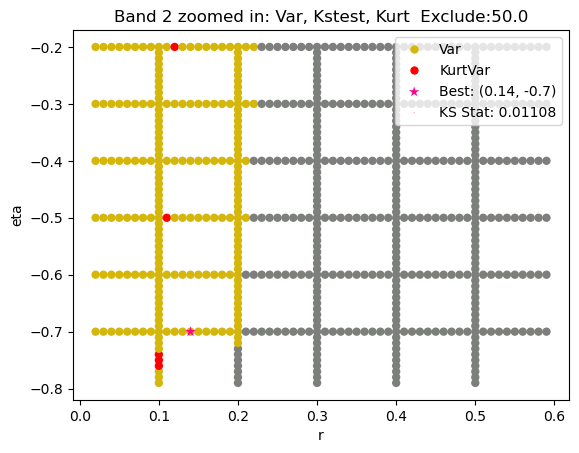

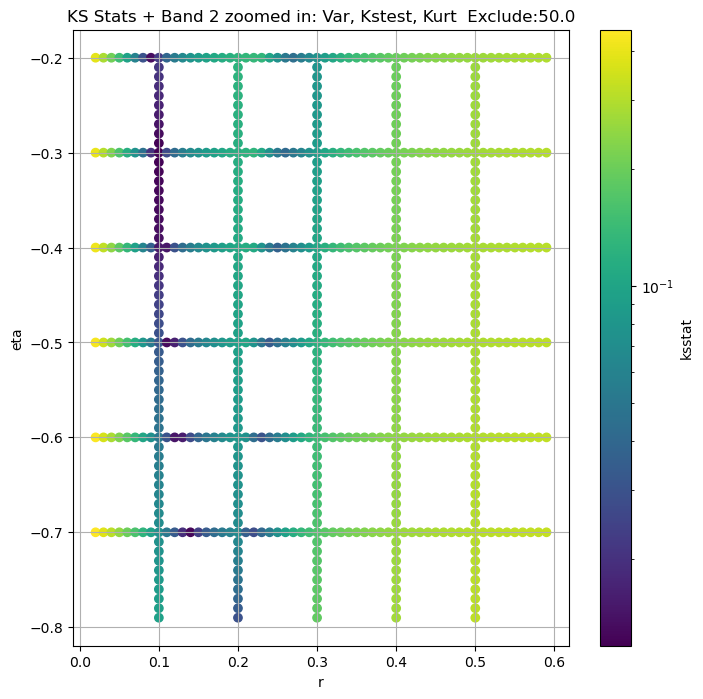

Band 5


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 5, 350.0 + 100 = 450, ksstat: 0.034669662234611986, var: 1364796416.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 5, 350.0 + 75 = 425, ksstat: 0.034520791519445815, var: 1378699776.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 5, 350.0 + 50 = 400, ksstat: 0.03408425988026555, var: 1392987648.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 5, 350.0 + 25 = 375, ksstat: 0.03398775000597548, var: 1407680384.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 5, 350.0 + 0 = 350, ksstat: 0.03370682452214657, var: 1422802688.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 5, 350.0 + -25 = 325, ksstat: 0.034105776185458236, var: 1438384640.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 5, 350.0 + -50 = 300, ksstat: 0.03446980522700627, var: 1454460288.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 5, 350.0 + -75 = 275, ksstat: 0.03435195176079127, var: 1471078144.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 5, 350.0 + -100 = 250, ksstat: 0.03378857524670478, var: 1488280320.0
Number of samples: 100000, Without approximation : 57630782.0


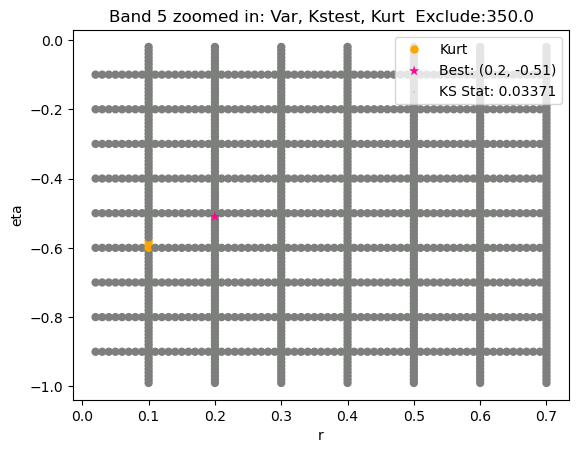

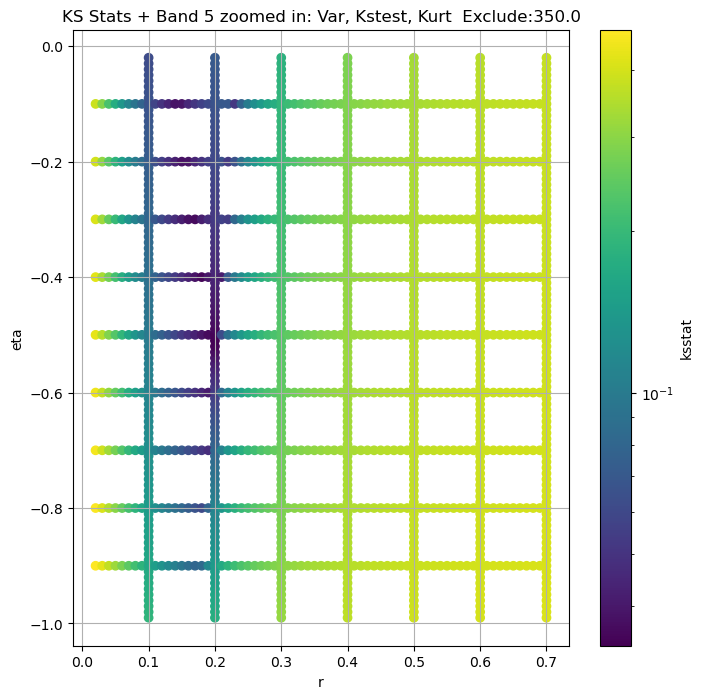

Band 8


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 8, 0.0 + 100 = 100, ksstat: 0.02601058375731119, var: 1503787264.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 8, 0.0 + 75 = 75, ksstat: 0.026046283104215917, var: 1522263296.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 8, 0.0 + 50 = 50, ksstat: 0.025584374532678644, var: 1542134784.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 8, 0.0 + 25 = 25, ksstat: 0.025414889551739386, var: 1563826048.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 8, 0.0 + 0 = 0, ksstat: 0.02511959043304257, var: 1588726912.0
Number of samples: 100000, Without approximation : 57630782.0


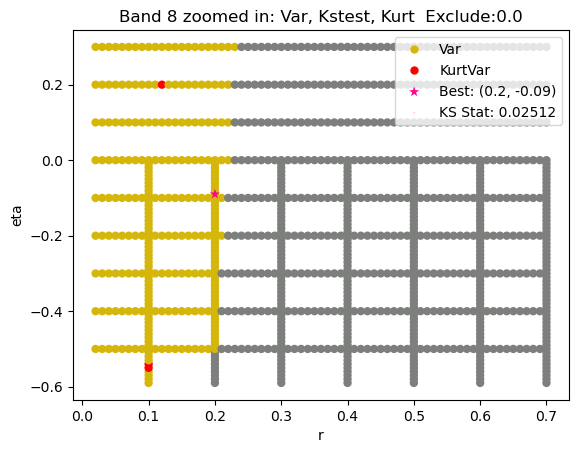

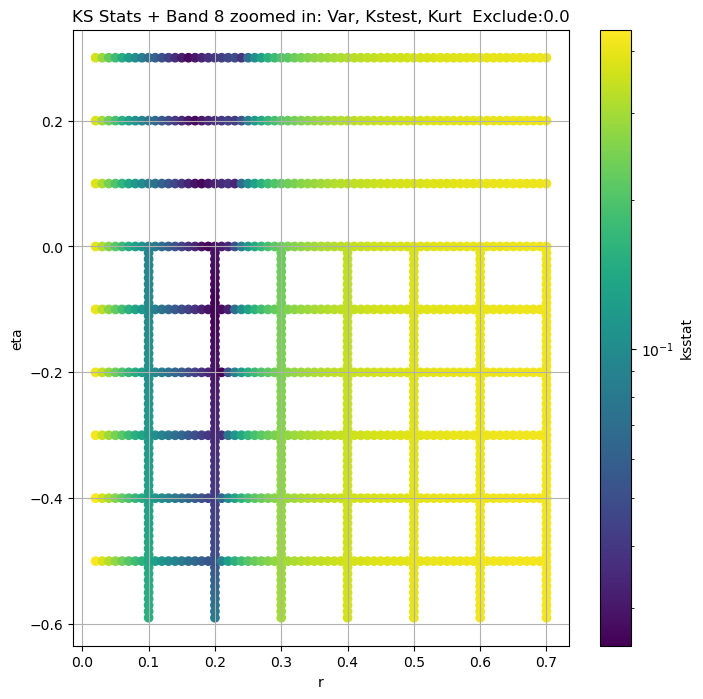

Band 11


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 100 = 100, ksstat: 0.02897166537751586, var: 1361681920.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 75 = 75, ksstat: 0.028540076370787537, var: 1374269184.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 50 = 50, ksstat: 0.02867158756785243, var: 1387424384.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 25 = 25, ksstat: 0.02845454148847304, var: 1401338496.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 0 = 0, ksstat: 0.028259711009305466, var: 1416652800.0
Number of samples: 100000, Without approximation : 57630782.0


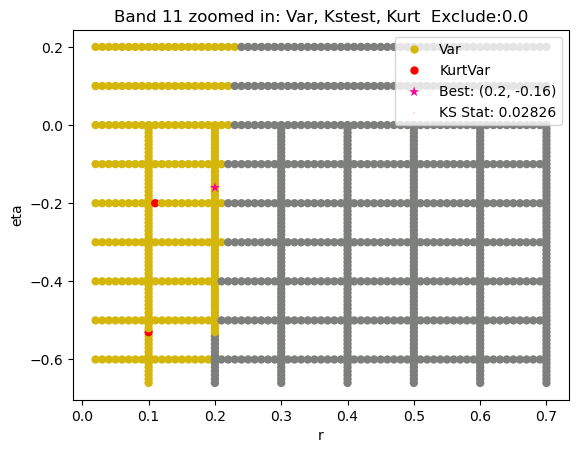

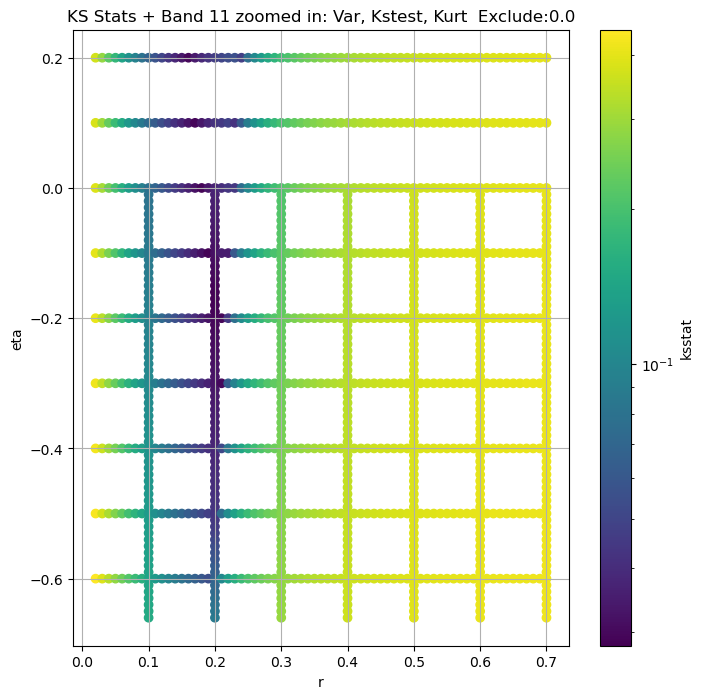

Band 14


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 100 = 125, ksstat: 0.02117752373988735, var: 377739392.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 75 = 100, ksstat: 0.020665346835186837, var: 383667712.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 50 = 75, ksstat: 0.020238147986190724, var: 389979968.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 25 = 50, ksstat: 0.019902558011973603, var: 396769568.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 0 = 25, ksstat: 0.019513729134200464, var: 404217632.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + -25 = 0, ksstat: 0.01900658855854831, var: 412908544.0
Number of samples: 100000, Without approximation : 57630782.0


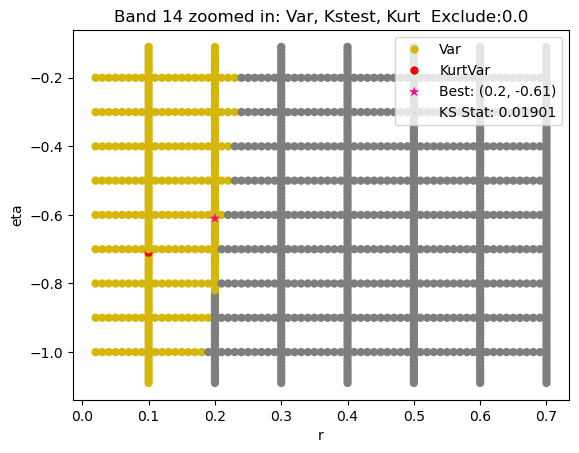

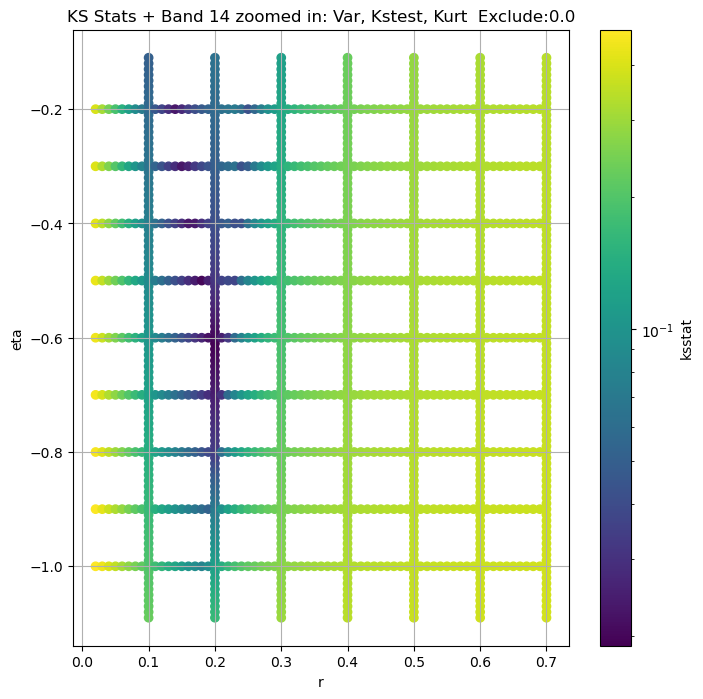

Band 18


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 18, 0.0 + 100 = 100, ksstat: 0.020122040882020298, var: 78954104.0


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 18, 0.0 + 75 = 75, ksstat: 0.019549172058389686, var: 80406760.0


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 18, 0.0 + 50 = 50, ksstat: 0.018429582227881935, var: 82041912.0


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 18, 0.0 + 25 = 25, ksstat: 0.01794195452974323, var: 83964288.0


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 18, 0.0 + 0 = 0, ksstat: 0.017552405746912858, var: 86651440.0
Number of samples: 100000, Without approximation : 57630782.0


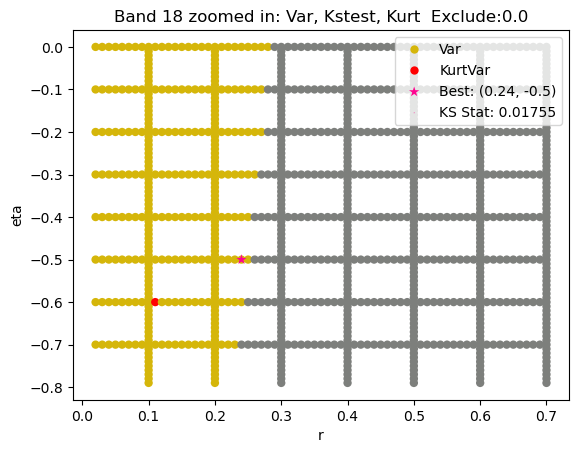

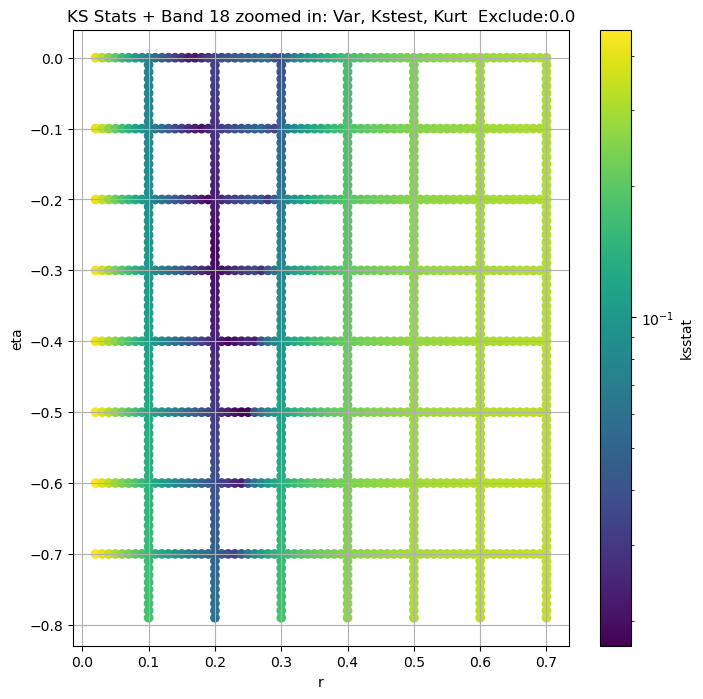

Band 21


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 100 = 100, ksstat: 0.0183865860056891, var: 29913908.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 75 = 75, ksstat: 0.01861208364467626, var: 30562776.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 50 = 50, ksstat: 0.018447018908223478, var: 31308454.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 25 = 25, ksstat: 0.01705787468280129, var: 32210282.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 0 = 0, ksstat: 0.015110703435709957, var: 33558248.0
Number of samples: 100000, Without approximation : 57630782.0


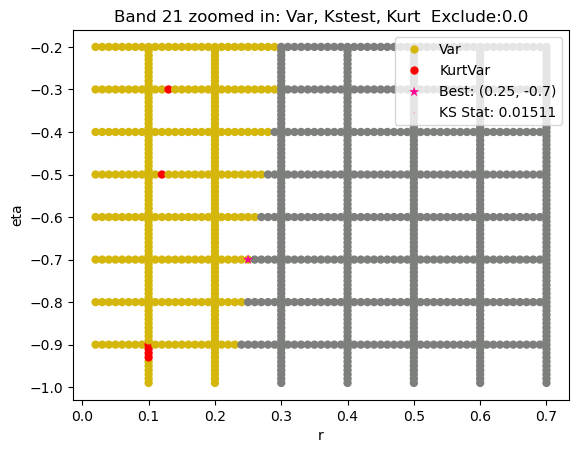

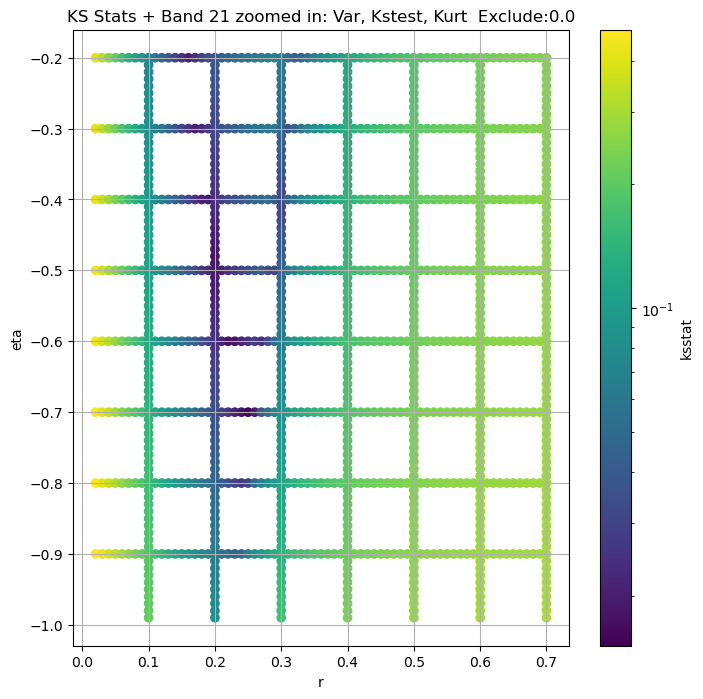

Band 24


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 100 = 100, ksstat: 0.010616693926044932, var: 13552396.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 75 = 75, ksstat: 0.00927745987051494, var: 14084056.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 50 = 50, ksstat: 0.0073520518500967, var: 14697531.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 25 = 25, ksstat: 0.00534587760005506, var: 15436296.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 0 = 0, ksstat: 0.005763686417268002, var: 16474387.0
Number of samples: 100000, Without approximation : 57630782.0


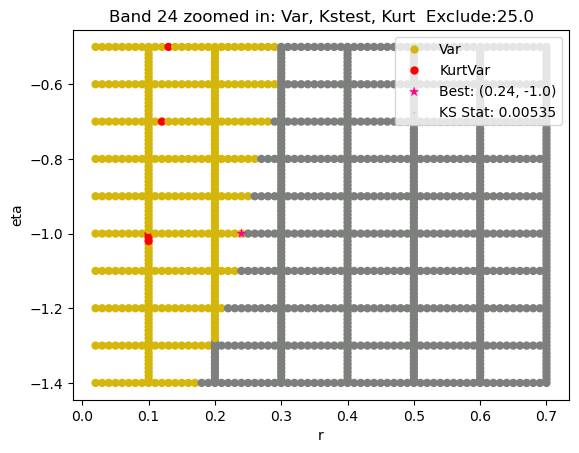

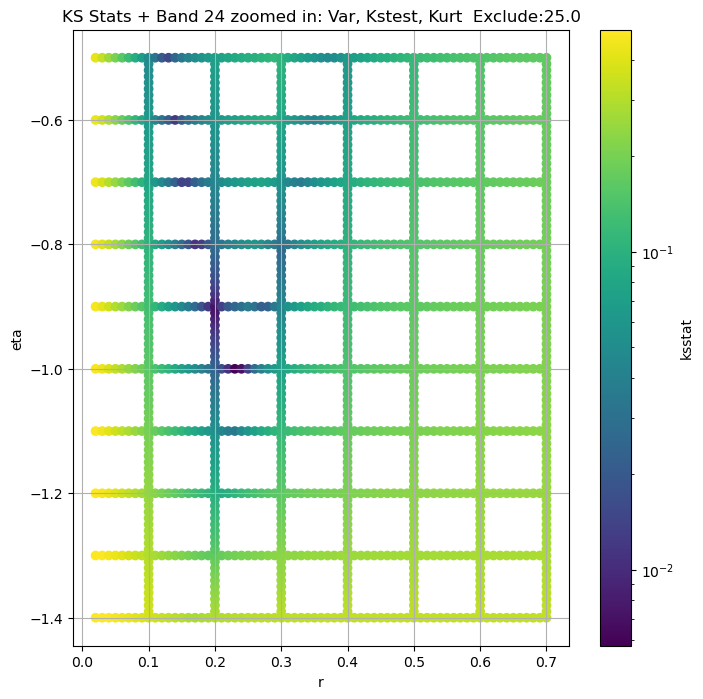

Band 27


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 250.0 + 100 = 350, ksstat: 0.008816985129986299, var: 3924144.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 250.0 + 75 = 325, ksstat: 0.008676660135927494, var: 4045224.25


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 250.0 + 50 = 300, ksstat: 0.008699837691225398, var: 4173921.25


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 250.0 + 25 = 275, ksstat: 0.008724432279600736, var: 4311130.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 250.0 + 0 = 250, ksstat: 0.008750297580111366, var: 4457948.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 250.0 + -25 = 225, ksstat: 0.008605814946556878, var: 4615678.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 250.0 + -50 = 200, ksstat: 0.008631829777370315, var: 4785922.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 250.0 + -75 = 175, ksstat: 0.008659542456723401, var: 4970698.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 250.0 + -100 = 150, ksstat: 0.008688340680273132, var: 5172590.0
Number of samples: 100000, Without approximation : 57630782.0


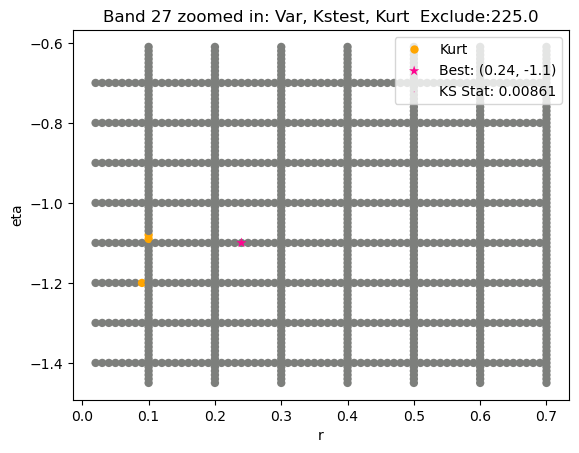

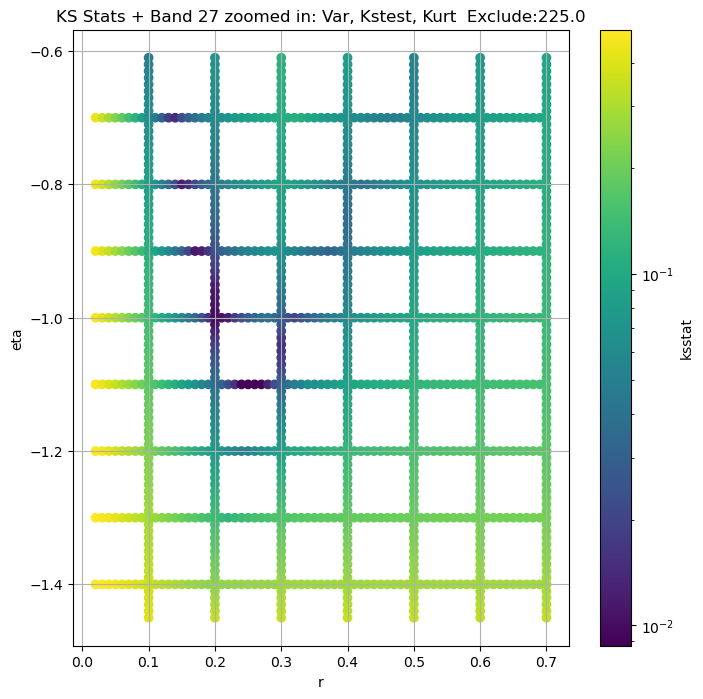

Band 31


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + 100 = 450, ksstat: 0.021963262396964556, var: 89090.7109375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + 75 = 425, ksstat: 0.021963262396964556, var: 91700.0


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + 50 = 400, ksstat: 0.021963262396964556, var: 94468.5859375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + 25 = 375, ksstat: 0.021963262396964556, var: 97413.5


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + 0 = 350, ksstat: 0.021963262396964556, var: 100555.46875


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + -25 = 325, ksstat: 0.021963262396964556, var: 103917.2109375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + -50 = 300, ksstat: 0.021963262396964556, var: 107525.84375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + -75 = 275, ksstat: 0.021963262396964556, var: 111416.2421875


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + -100 = 250, ksstat: 0.021963262396964556, var: 115629.65625
Number of samples: 100000, Without approximation : 57630782.0


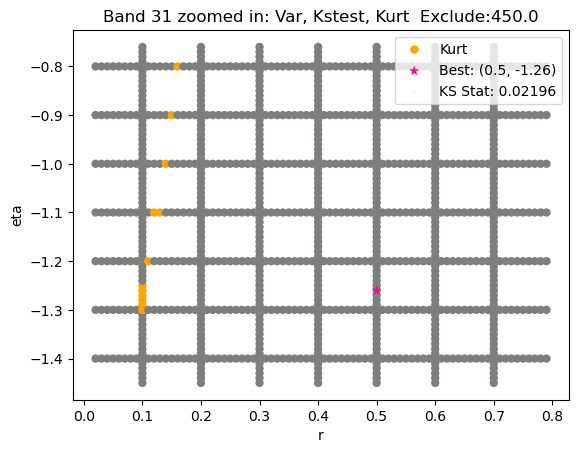

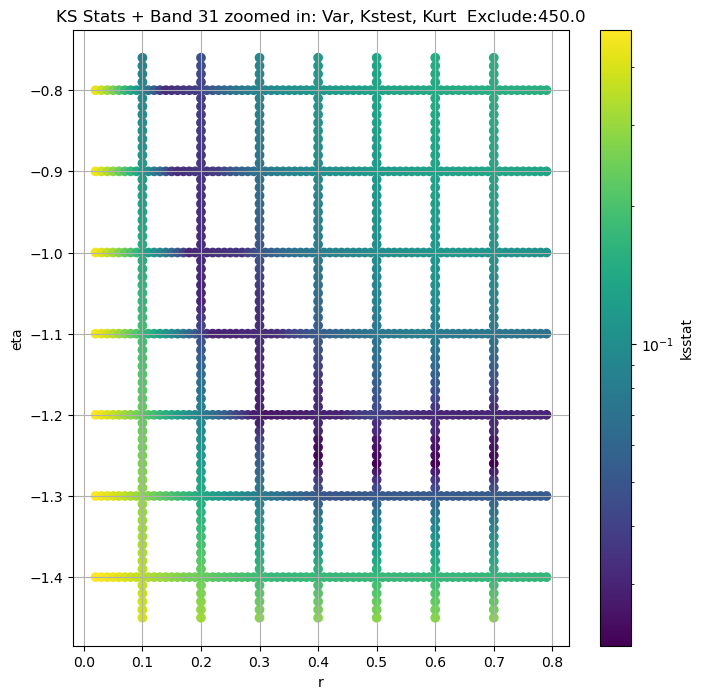

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     6.853427e+08  6.000865e+08  7.770383e+08  22.935051   19.237541   
5     1.721802e+09  1.590356e+09  1.858356e+09   7.159598    6.277525   
8     1.588727e+09  1.482723e+09  1.697909e+09   4.966211    4.375383   
11    1.416653e+09  1.330225e+09  1.504607e+09   3.758611    3.396935   
14    4.129085e+08  3.789787e+08  4.479632e+08   8.569131    7.614952   
18    8.665144e+07  7.953336e+07  9.428525e+07   8.930678    7.110191   
21    3.355825e+07  3.043884e+07  3.696326e+07  12.006084    8.988194   
24    1.647439e+07  1.424752e+07  1.894558e+07  28.794476   22.496632   
27    7.202204e+06  6.039485e+06  8.489410e+06  41.684950   32.753284   
31    2.123527e+05  1.700635e+05  2.704926e+05  79.023926   42.148514   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      27.800936     57630782.0             0.011951        0.1         -0.3   
5       8.111173     57630782.0             0.034698        0.2         -0.5   
8       5.579913     57630782.0             0.025161        0.2         -0.1   
11      4.138503     57630782.0             0.029308        0.2         -0.2   
14      9.577575     57630782.0             0.019514        0.2         -0.6   
18     11.247792     57630782.0             0.019880        0.2         -0.3   
21     16.476372     57630782.0             0.018566        0.2         -0.5   
24     36.237900     57630782.0             0.007105        0.2         -0.9   
27     52.515106     57630782.0             0.009866        0.2         -1.0   
31    215.783400     57630782.0             0.028060        0.3         -1.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2          0.000510                    25.0        6.295416e+08   
5      94100.706878                   350.0        1.422803e+09   
8      28656.690332                     0.0        1.588727e+09   
11     34273.383005                     0.0        1.416653e+09   
14     39413.636284                    25.0        4.129085e+08   
18      2865.457672                     0.0        8.665144e+07   
21      2219.460847                     0.0        3.355825e+07   
24      6537.455159                     0.0        1.543630e+07   
27      3166.929781                   250.0        4.615678e+06   
31     10858.502435                   350.0        8.909071e+04   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.000179          0.011081    0.14     -0.70   
5                    0.000179          0.033707    0.20     -0.51   
8                    0.000179          0.025120    0.20     -0.09   
11                   0.000179          0.028260    0.20     -0.16   
14                   0.000179          0.019007    0.20     -0.61   
18                   0.000179          0.017552    0.24     -0.50   
21                   0.000179          0.015111    0.25     -0.70   
24                   0.000179          0.005346    0.24     -1.00   
27                   0.000179          0.008606    0.24     -1.10   
31                   0.000179          0.021963    0.50     -1.26   

         best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                   
2        139.894253                 50.0        15828  
5      97689.422845                350.0         1666  
8      27853.984907                  0.0         2965  
11     30410.469971                  0.0         2223  
14     41929.980449                  0.0         5275  
18     64735.614399                  0.0         5934  
21     77447.067382                  0.0         7914  
24     86687.203740                

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

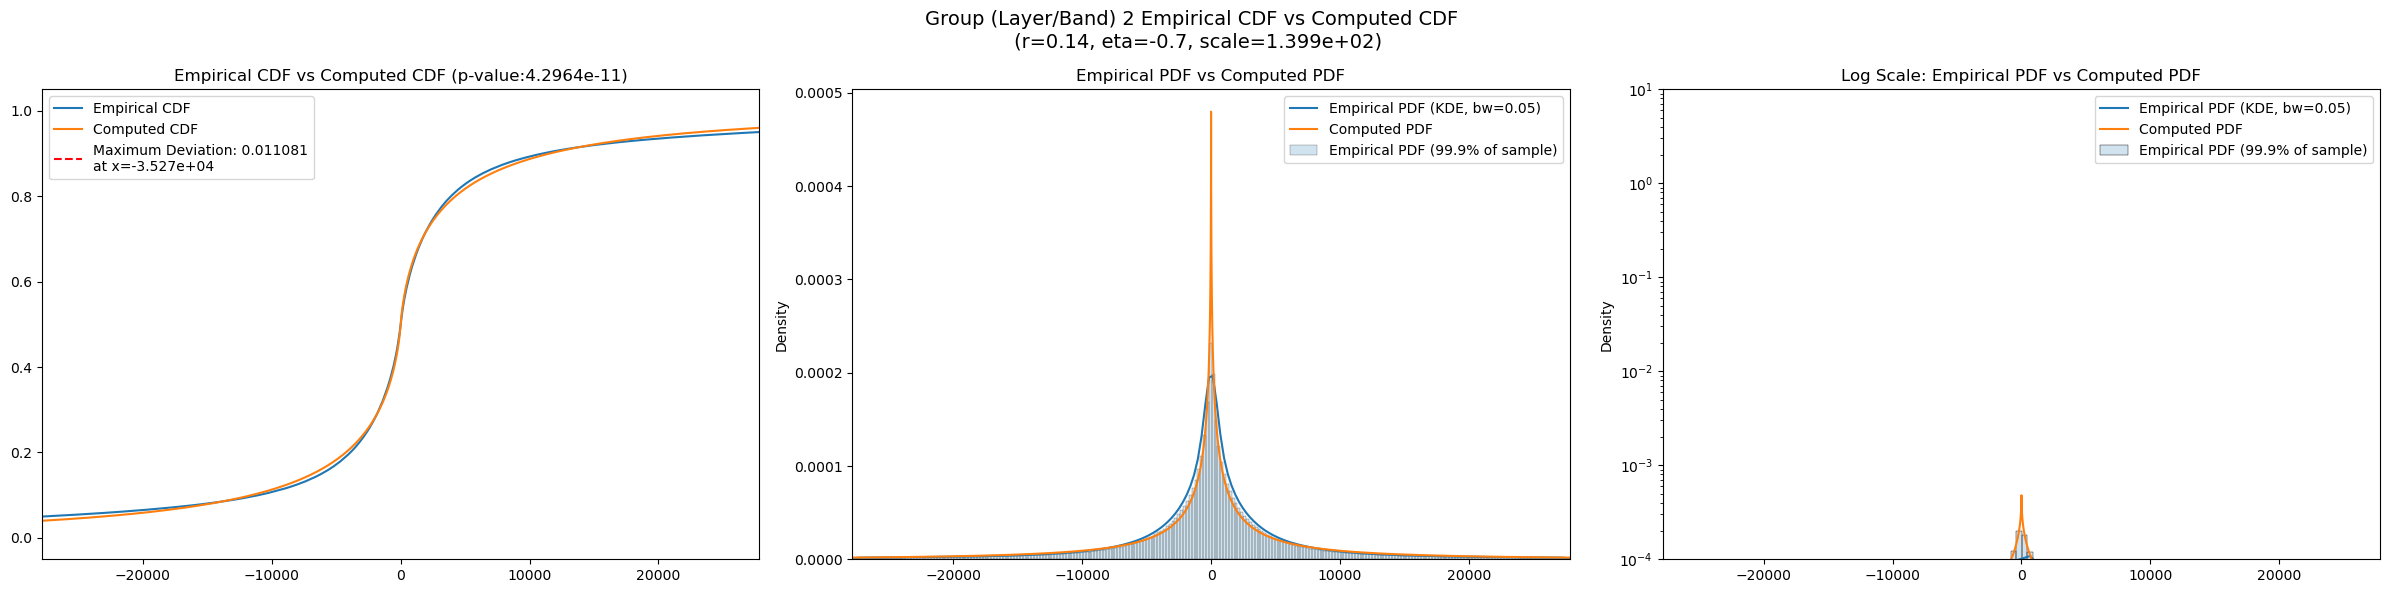

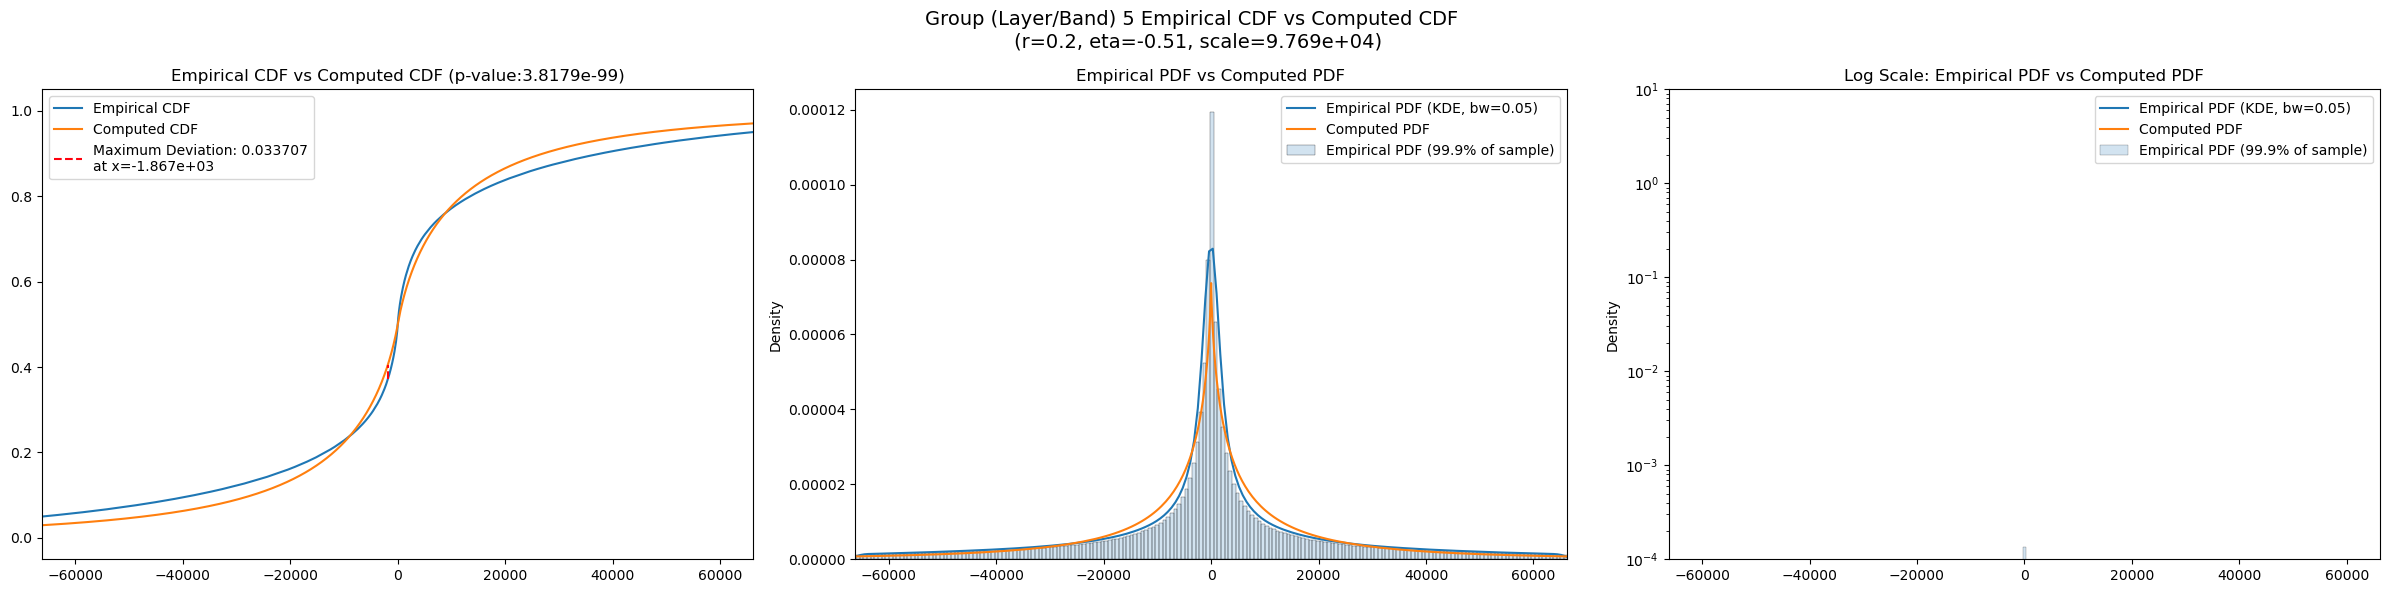

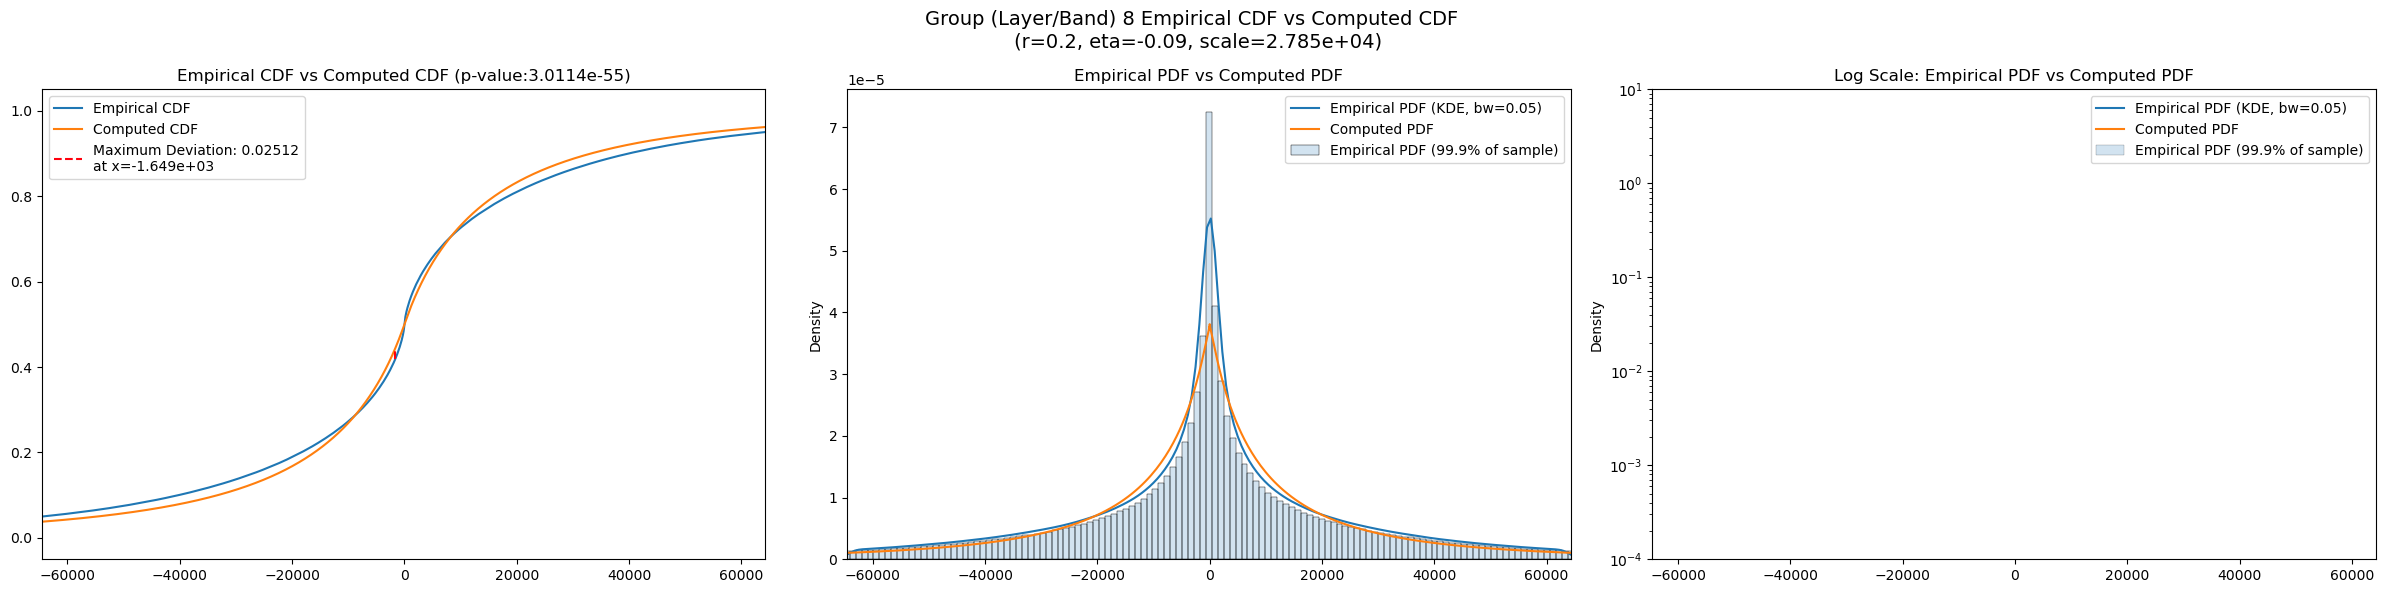

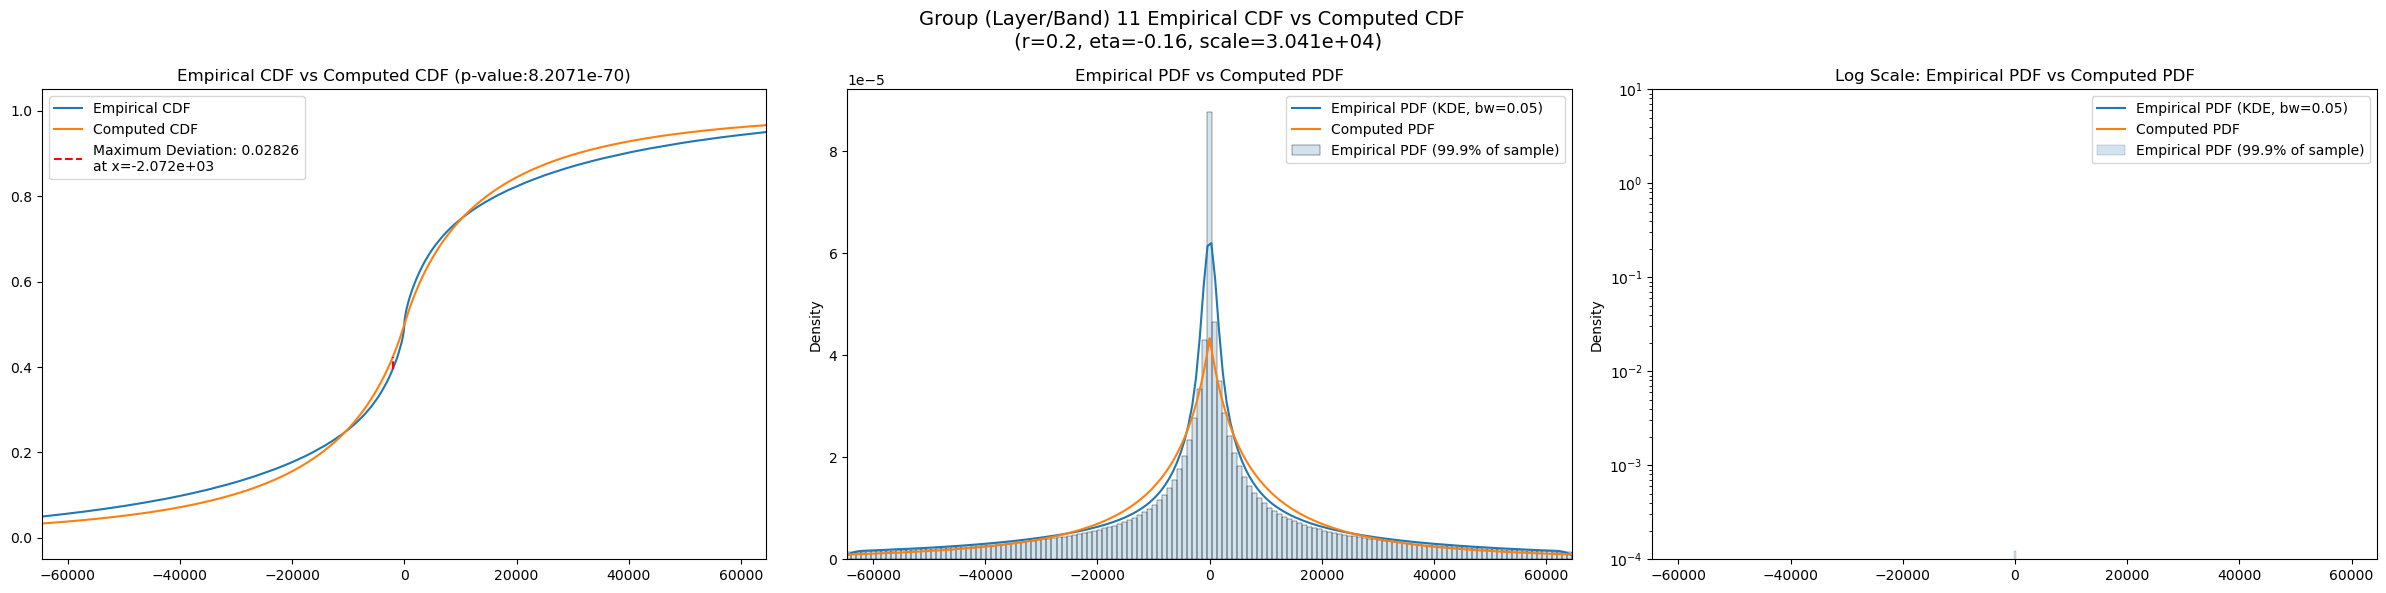

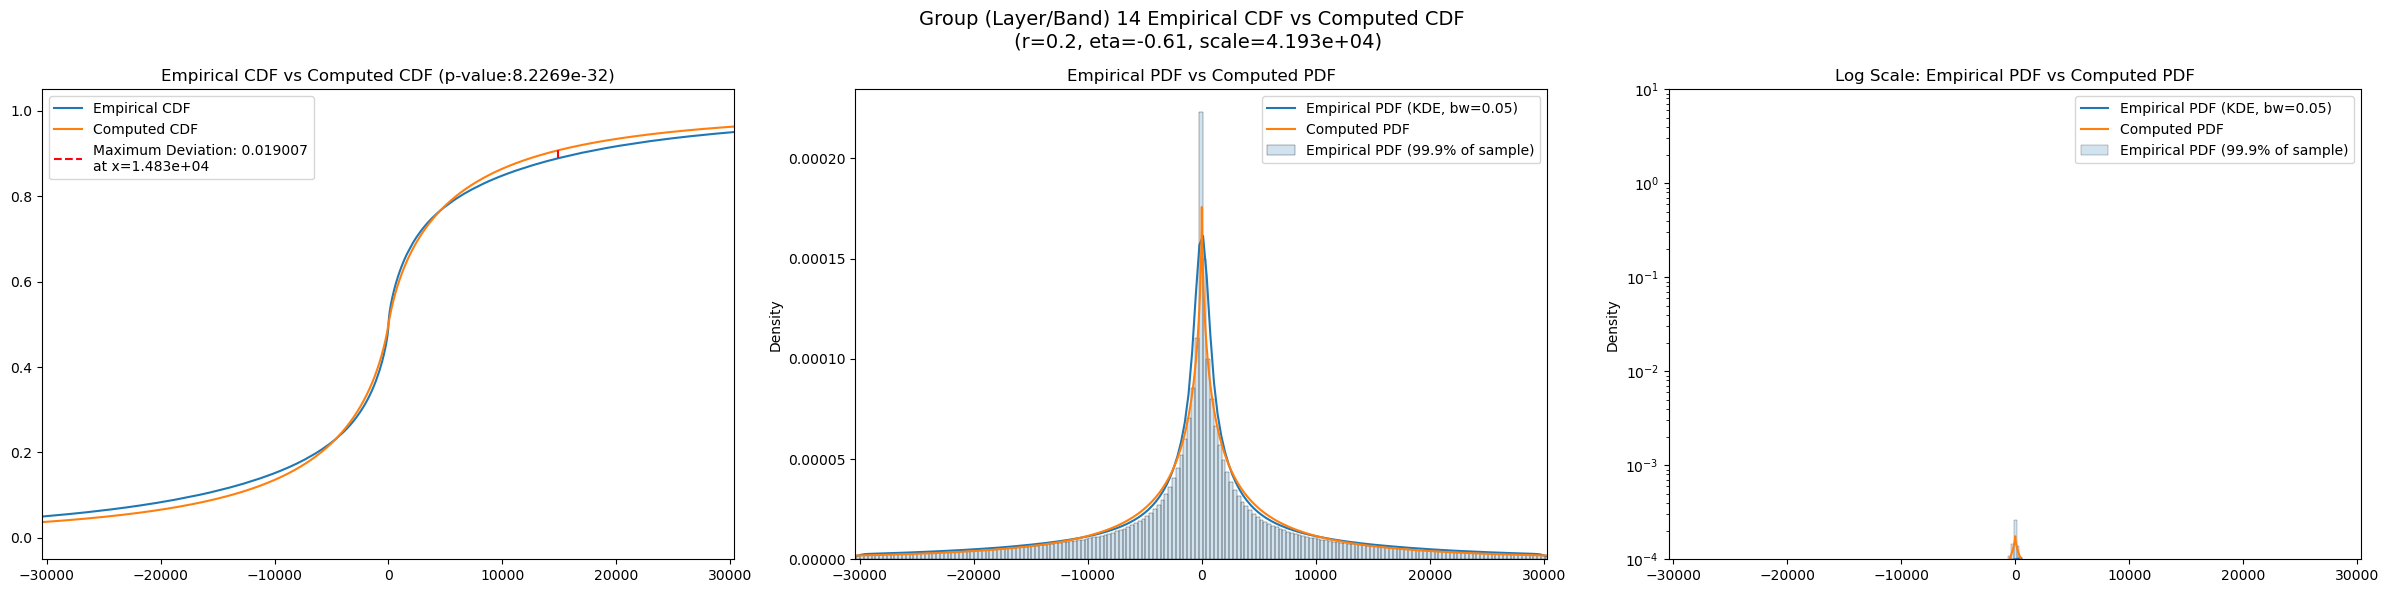

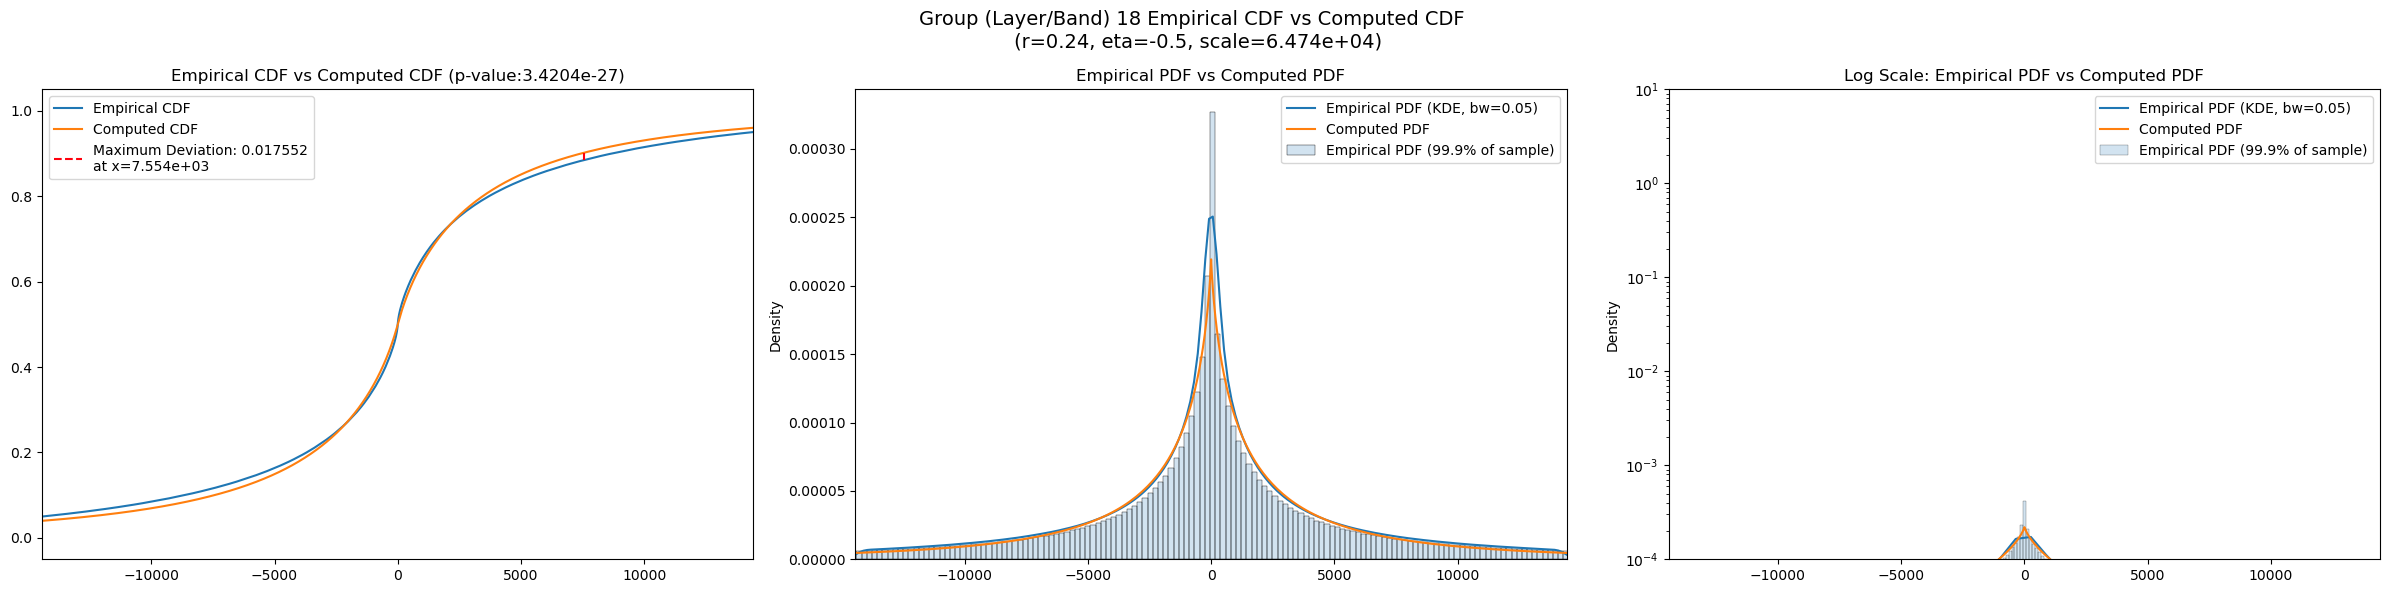

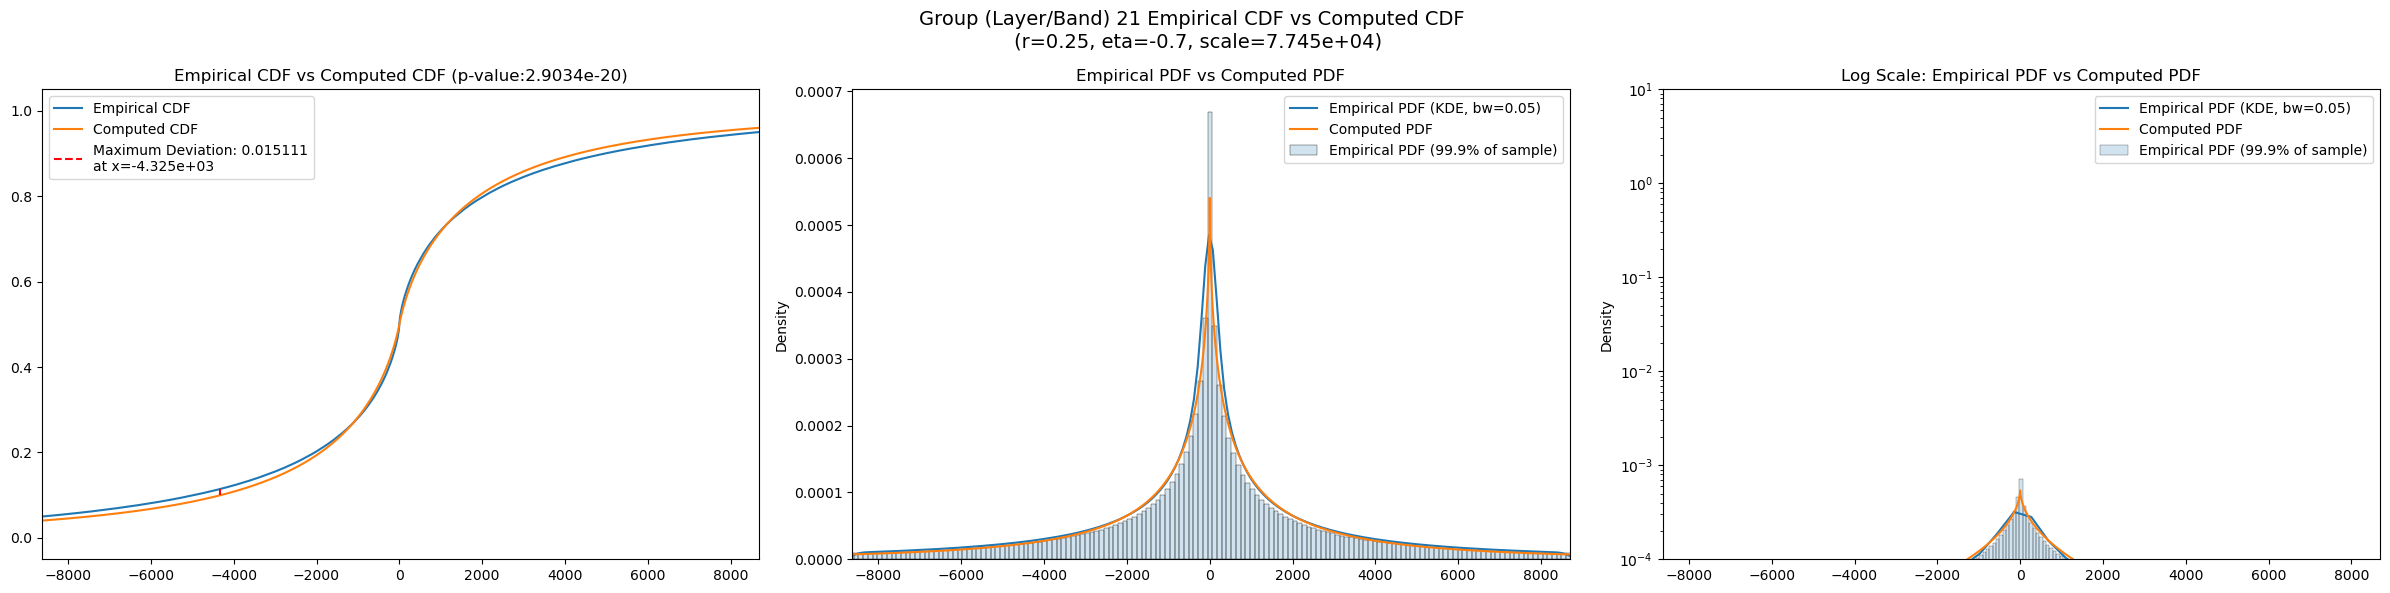

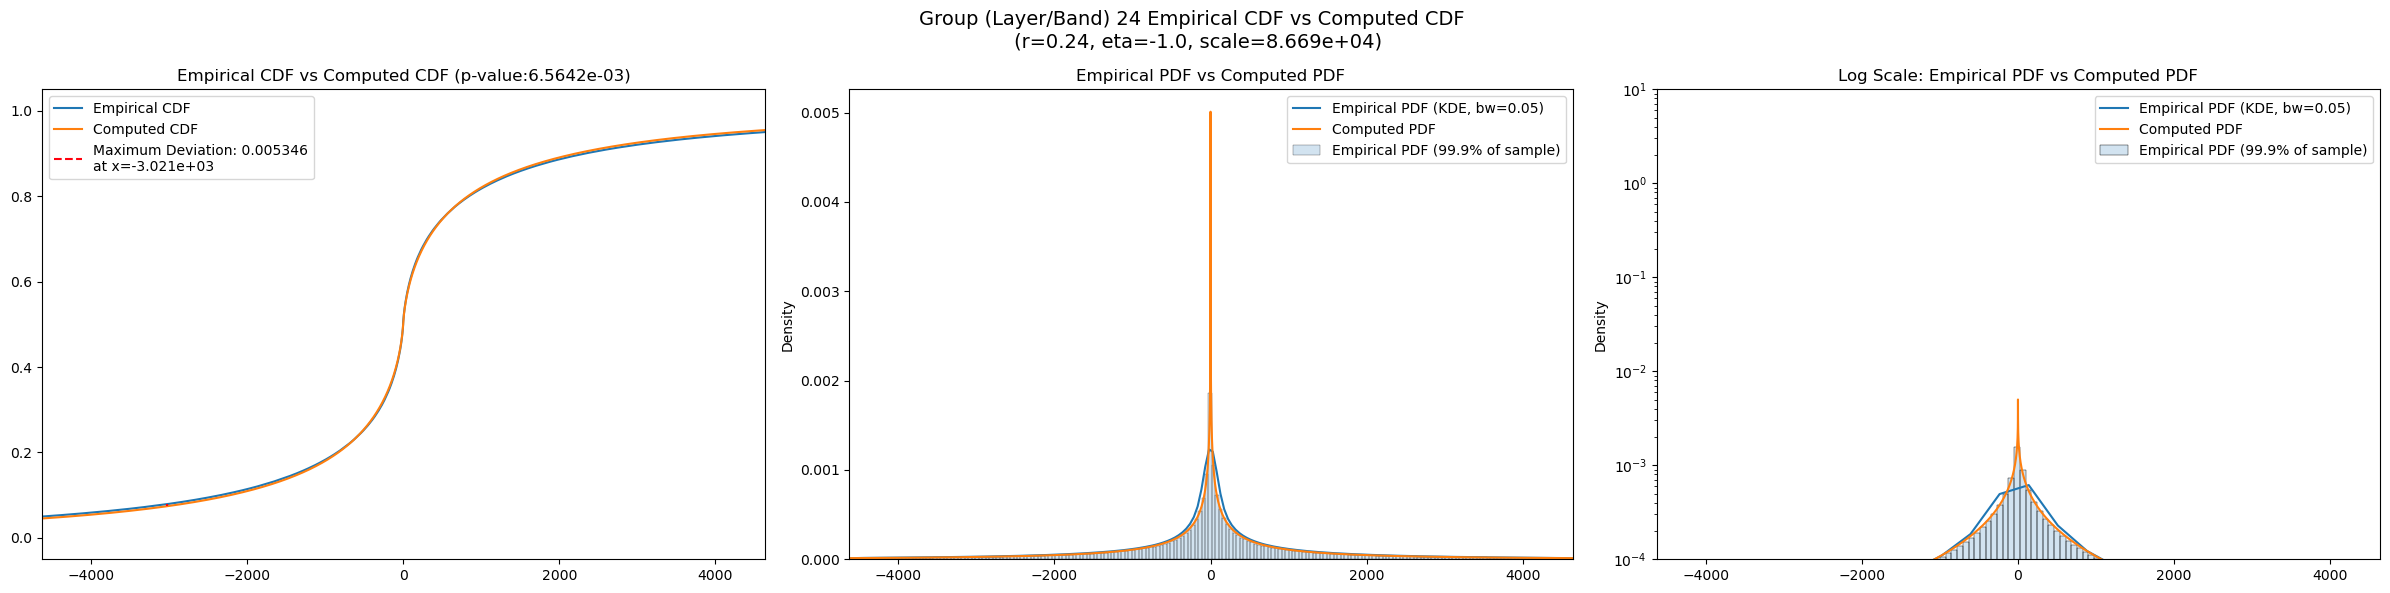

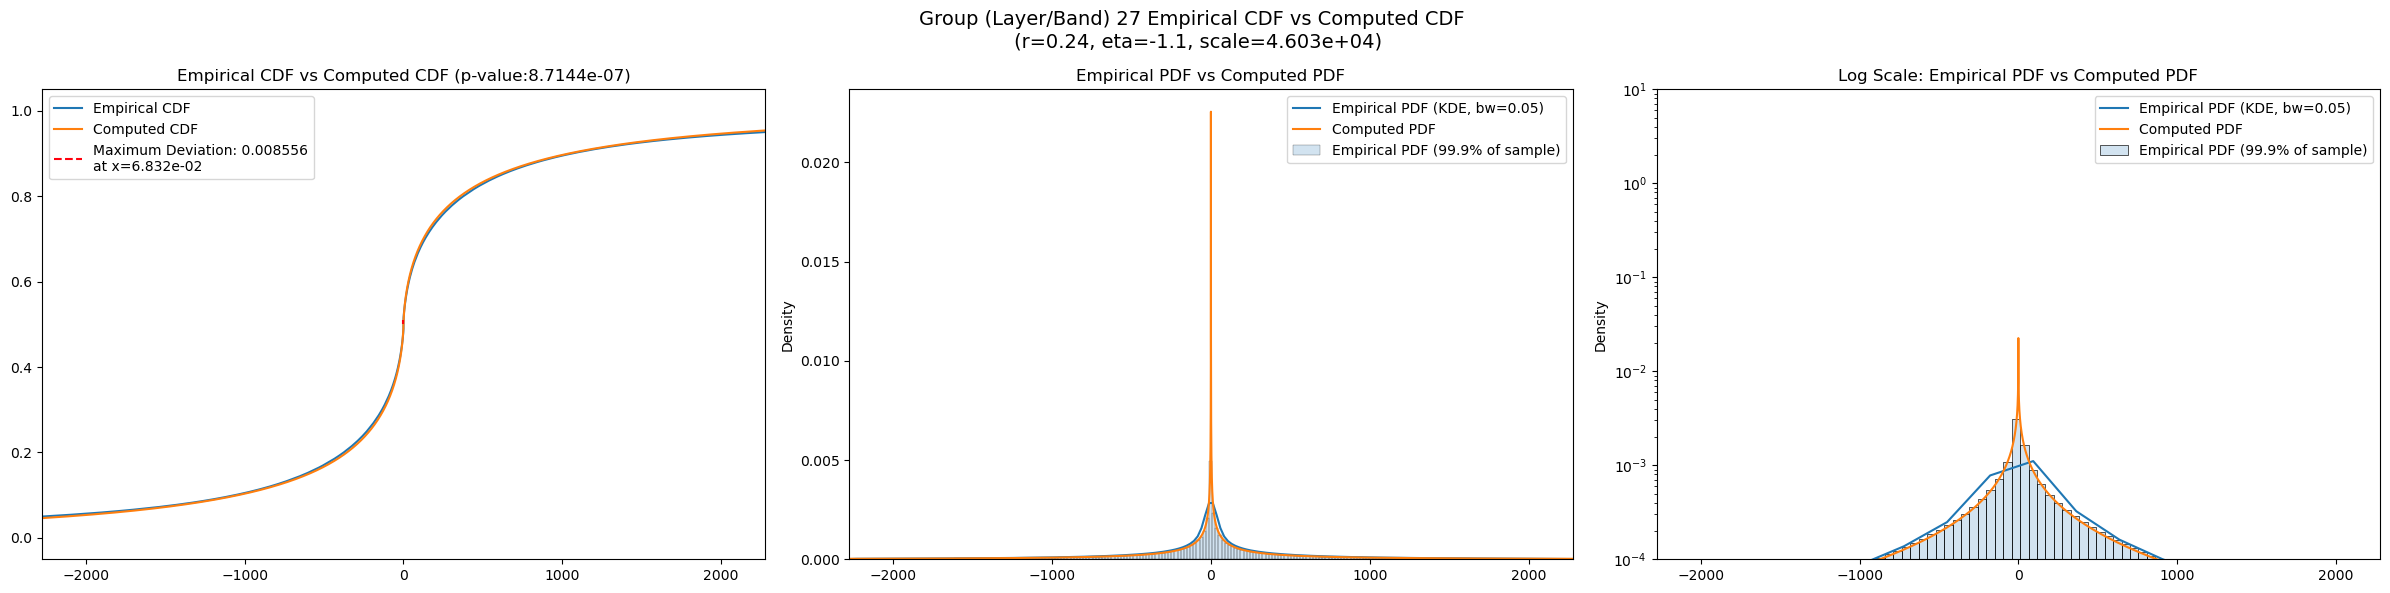

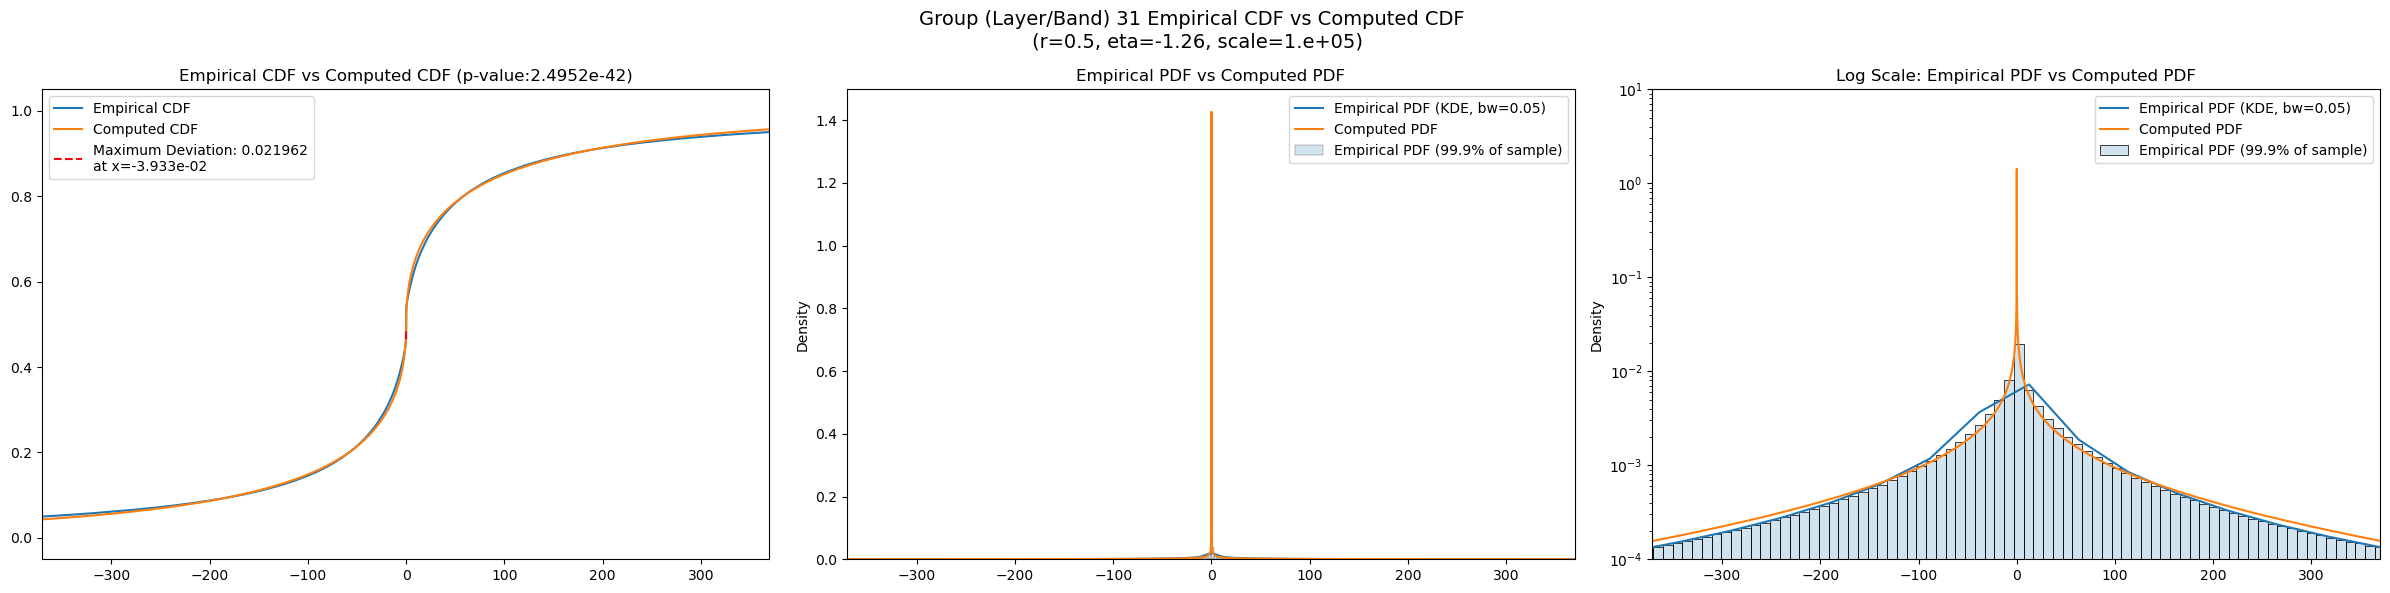

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     6.853427e+08  6.000865e+08  7.770383e+08  22.935051   19.237541   
5     1.721802e+09  1.590356e+09  1.858356e+09   7.159598    6.277525   
8     1.588727e+09  1.482723e+09  1.697909e+09   4.966211    4.375383   
11    1.416653e+09  1.330225e+09  1.504607e+09   3.758611    3.396935   
14    4.129085e+08  3.789787e+08  4.479632e+08   8.569131    7.614952   
18    8.665144e+07  7.953336e+07  9.428525e+07   8.930678    7.110191   
21    3.355825e+07  3.043884e+07  3.696326e+07  12.006084    8.988194   
24    1.647439e+07  1.424752e+07  1.894558e+07  28.794476   22.496632   
27    7.202204e+06  6.039485e+06  8.489410e+06  41.684950   32.753284   
31    2.123527e+05  1.700635e+05  2.704926e+05  79.023926   42.148514   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      27.800936     57630782.0             0.011951        0.1         -0.3   
5       8.111173     57630782.0             0.034698        0.2         -0.5   
8       5.579913     57630782.0             0.025161        0.2         -0.1   
11      4.138503     57630782.0             0.029308        0.2         -0.2   
14      9.577575     57630782.0             0.019514        0.2         -0.6   
18     11.247792     57630782.0             0.019880        0.2         -0.3   
21     16.476372     57630782.0             0.018566        0.2         -0.5   
24     36.237900     57630782.0             0.007105        0.2         -0.9   
27     52.515106     57630782.0             0.009866        0.2         -1.0   
31    215.783400     57630782.0             0.028060        0.3         -1.2   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       5524.8600              0.080258                   0.0   
5     ...      16124.4000              0.093362                   0.0   
8     ...      21893.4000              0.067872                   0.0   
11    ...      19817.1000              0.076975                   0.0   
14    ...       7865.4700              0.083764                   0.0   
18    ...       4670.1000              0.069996                   0.0   
21    ...       2550.4200              0.075281                   0.0   
24    ...       1054.7800              0.087455                   0.0   
27    ...        466.3170              0.089493                   0.0   
31    ...         73.4822              0.090127                   0.0   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
band                                                                        
2          4993.310             0.057452                  0.0   3724.3600   
5         13754.400             0.068831                  0.0  10651.4000   
8         18555.500             0.043409                  0.0  14838.5000   
11        16966.200             0.051414                  0.0  13398.0000   
14         6772.470             0.058465                  0.0   5257.5000   
18         4013.980             0.044174                  0.0   3157.3600   
21         2187.270             0.050096                  0.0   1705.1800   
24          906.034             0.063224                  0.0    693.6130   
27          398.095             0.066202                  0.0    302.4980   
31           62.974             0.067119                  0.0     47.3844   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.052979            0.0                   0.0  
5          0.069940            0.0                   0.0  
8          0.047269            0.0                   0.0  
11         0.053944            0.0                   0.0  
14         0.0594

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.011951                 0.000179          0.011081   
5                0.034698                 0.000179          0.033707   
8                0.025161                 0.000179          0.025120   
11               0.029308                 0.000179          0.028260   
14               0.019514                 0.000179          0.019007   
18               0.019880                 0.000179          0.017552   
21               0.018566                 0.000179          0.015111   
24               0.007105                 0.000179          0.005346   
27               0.009866                 0.000179          0.008606   
31               0.028060                 0.000179          0.021963   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.080258             0.057452       0.052979  
5                 0.093362             0.068831       0.069940  
8                 0.067872             0.043409       0.047269  
11                0.076975             0.051414       0.053944  
14                0.083764             0.058465       0.059458  
18                0.069996             0.044174       0.046384  
21                0.075281             0.050096       0.051734  
24                0.087455             0.063224       0.063505  
27                0.089493             0.066202       0.066409  
31                0.090127             0.067119       0.066868

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta     best_scale  \
band                                                                          
2           6.295416e+08          0.011081    0.14     -0.70     139.894253   
5           1.422803e+09          0.033707    0.20     -0.51   97689.422845   
8           1.588727e+09          0.025120    0.20     -0.09   27853.984907   
11          1.416653e+09          0.028260    0.20     -0.16   30410.469971   
14          4.129085e+08          0.019007    0.20     -0.61   41929.980449   
18          8.665144e+07          0.017552    0.24     -0.50   64735.614399   
21          3.355825e+07          0.015111    0.25     -0.70   77447.067382   
24          1.543630e+07          0.005346    0.24     -1.00   86687.203740   
27          4.615678e+06          0.008606    0.24     -1.10   46026.455698   
31          8.909071e+04          0.021963    0.50     -1.26  100000.000000   

      best_exclude_cutoff  
band                       
2                    50.0  
5                   350.0  
8                     0.0  
11                    0.0  
14                    0.0  
18                    0.0  
21                    0.0  
24                   25.0  
27                  225.0  
31                  450.0